In [87]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

#TRABALHANDO COM OS DADOS

In [88]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2021-06-13 03:52:06--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 668352 (653K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv.1’

time_series_covid19 100%[===================>] 652.69K  --.-KB/s    in 0.03s   

2021-06-13 03:52:06 (22.5 MB/s) - ‘time_series_covid19_confirmed_global.csv.1’ saved [668352/668352]



In [89]:
covid_data = pd.read_csv("/content/time_series_covid19_confirmed_global.csv")

#Restringindo dados a 27 de dezembro e removendo colunas longas, pois não são necessárias
covid_data = covid_data.drop(['Lat','Long'],axis=1)

#Agrupando países de acordo com suas províncias, pois estamos lidando com nível de país
covid_data_grouped = covid_data.groupby("Country/Region").sum().reset_index()

covid_data_grouped.head(5)

Country/Region  1/22/20  1/23/20  1/24/20  ...  6/8/21  6/9/21  6/10/21  6/11/21
0    Afghanistan        0        0        0  ...   82326   84050    85892    87716
1        Albania        0        0        0  ...  132397  132415   132426   132437
2        Algeria        0        0        0  ...  131647  132034   132355   132727
3        Andorra        0        0        0  ...   13781   13791    13805    13813
4         Angola        0        0        0  ...   36004   36115    36325    36455

[5 rows x 508 columns]

In [90]:
#Separando conjunto de dados do Brasil para comparação
covid_data_brazil = covid_data_grouped.loc[covid_data_grouped["Country/Region"]=="Brazil"]
covid_data_brazil

Country/Region  1/22/20  1/23/20  ...    6/9/21   6/10/21   6/11/21
23         Brazil        0        0  ...  17122877  17210969  17296118

[1 rows x 508 columns]

In [91]:
# Matriz Numpy de dados COVID_19_BRAZIL
covid_data_brazil_array = covid_data_brazil.to_numpy()

# Nº de países
c = covid_data_brazil_array.shape[0]

# Loop (Percorra) todos os países 
for x in range(0,c):
    
    zeros = covid_data_brazil_array[x,1:].shape[0]-np.count_nonzero(covid_data_brazil_array[x,1:])
    # Substitua os primeiros índices na matriz pelos primeirosvalores diferentes de zero na matriz.
    covid_data_brazil_array[x,1:455] = covid_data_brazil_array[x,zeros+1:zeros+455]


# Criando uma nova coluna com o nome do dia e anexando 
column_new = ["Country/Region"]

for x in range(0,454):
    column_new.append("Day"+str(x+1))

# novo dataframe que contem os dados diferentes de zero    
covid_365days = pd.DataFrame(data=covid_data_brazil_array[:,0:455],columns=column_new)

#
covid_transposed = covid_365days.set_index("Country/Region").transpose()

In [92]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [93]:
dataset = covid_transposed.values
dataset = dataset.astype('float32')

In [94]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [95]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

408 46


In [96]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

#LSTM

In [97]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [98]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [99]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
406/406 - 2s - loss: 0.0665
Epoch 2/100
406/406 - 1s - loss: 0.0279
Epoch 3/100
406/406 - 1s - loss: 0.0087
Epoch 4/100
406/406 - 1s - loss: 8.1073e-04
Epoch 5/100
406/406 - 1s - loss: 5.5676e-05
Epoch 6/100
406/406 - 1s - loss: 4.0795e-05
Epoch 7/100
406/406 - 1s - loss: 3.7965e-05
Epoch 8/100
406/406 - 1s - loss: 3.4520e-05
Epoch 9/100
406/406 - 1s - loss: 3.2537e-05
Epoch 10/100
406/406 - 1s - loss: 2.9775e-05
Epoch 11/100
406/406 - 1s - loss: 2.7144e-05
Epoch 12/100
406/406 - 1s - loss: 2.6082e-05
Epoch 13/100
406/406 - 1s - loss: 2.5068e-05
Epoch 14/100
406/406 - 1s - loss: 2.5272e-05
Epoch 15/100
406/406 - 1s - loss: 2.5099e-05
Epoch 16/100
406/406 - 1s - loss: 2.7073e-05
Epoch 17/100
406/406 - 1s - loss: 2.7830e-05
Epoch 18/100
406/406 - 1s - loss: 2.5375e-05
Epoch 19/100
406/406 - 1s - loss: 2.4431e-05
Epoch 20/100
406/406 - 1s - loss: 2.5138e-05
Epoch 21/100
406/406 - 1s - loss: 2.8113e-05
Epoch 22/100
406/406 - 1s - loss: 2.4713e-05
Epoch 23/100
406/406 - 1s - los

In [100]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 81230.36 RMSE
Test Score: 111486.11 RMSE


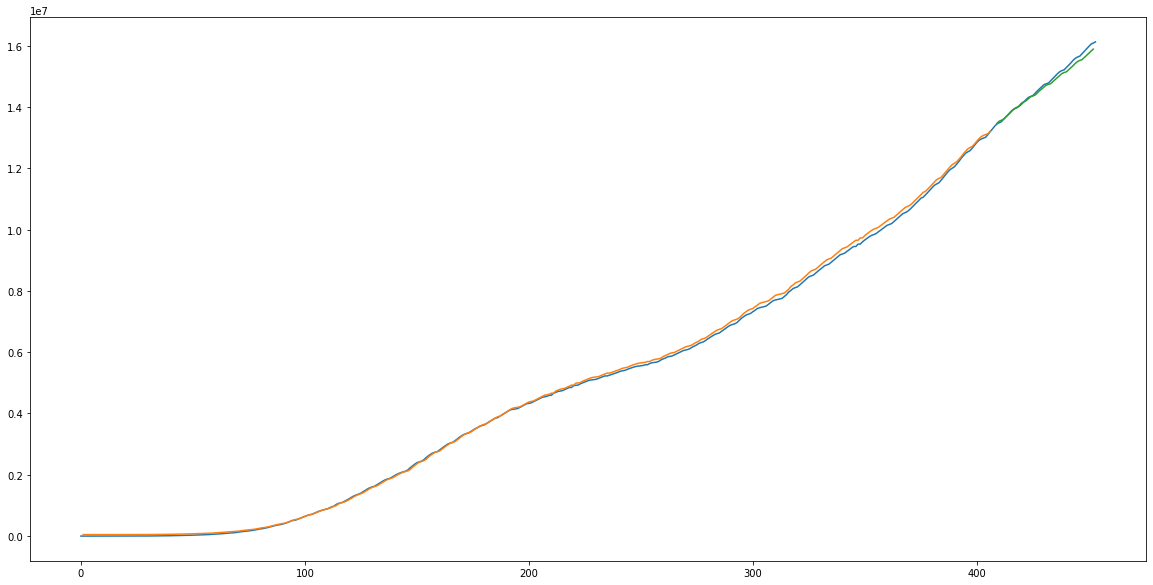

In [101]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [102]:
def entry_diff(entry,interval= 1):
    new_entry = np.copy(entry)
    for x in range(1,entry.shape[0]):
        new_entry[x] = entry[x] - entry[x-1]
    return new_entry

def remove(entry):
    remove_zero = np.copy(entry)
    total =remove_zero.shape[0]-np.count_nonzero(remove_zero)
    return entry[total:]

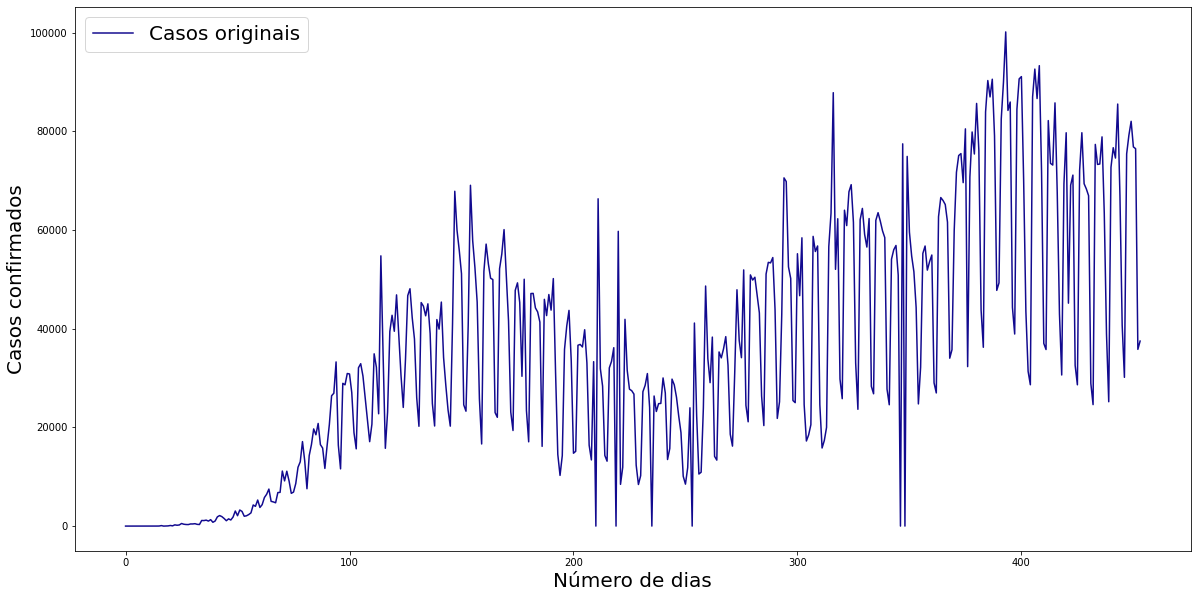

In [103]:
plt.figure(figsize=(20,10))
plt.plot(entry_diff(remove(covid_transposed["Brazil"]).to_numpy()),color='#120A8F', linewidth=1.5, linestyle='solid', label='Casos originais')
plt.legend(loc=2, prop={'size': 20})
plt.xlabel('Número de dias', fontsize=20)
plt.ylabel('Casos confirmados', fontsize=20)
plt.show()

In [104]:
train_set = entry_diff(remove(covid_transposed["Brazil"].to_numpy()))
train_set = train_set[:]
train_set = train_set.reshape(-1, 1)


In [105]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(train_set)

In [106]:
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

408 46


In [107]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [108]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [109]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [110]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
406/406 - 2s - loss: 0.0903
Epoch 2/100
406/406 - 1s - loss: 0.0447
Epoch 3/100
406/406 - 1s - loss: 0.0377
Epoch 4/100
406/406 - 1s - loss: 0.0321
Epoch 5/100
406/406 - 1s - loss: 0.0286
Epoch 6/100
406/406 - 1s - loss: 0.0263
Epoch 7/100
406/406 - 1s - loss: 0.0257
Epoch 8/100
406/406 - 1s - loss: 0.0252
Epoch 9/100
406/406 - 1s - loss: 0.0250
Epoch 10/100
406/406 - 1s - loss: 0.0251
Epoch 11/100
406/406 - 1s - loss: 0.0251
Epoch 12/100
406/406 - 1s - loss: 0.0252
Epoch 13/100
406/406 - 1s - loss: 0.0252
Epoch 14/100
406/406 - 1s - loss: 0.0249
Epoch 15/100
406/406 - 1s - loss: 0.0248
Epoch 16/100
406/406 - 1s - loss: 0.0249
Epoch 17/100
406/406 - 1s - loss: 0.0248
Epoch 18/100
406/406 - 1s - loss: 0.0252
Epoch 19/100
406/406 - 1s - loss: 0.0249
Epoch 20/100
406/406 - 1s - loss: 0.0251
Epoch 21/100
406/406 - 1s - loss: 0.0250
Epoch 22/100
406/406 - 1s - loss: 0.0249
Epoch 23/100
406/406 - 1s - loss: 0.0250
Epoch 24/100
406/406 - 1s - loss: 0.0250
Epoch 25/100
406/406 - 1s

In [111]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15807.28 RMSE
Test Score: 22659.38 RMSE


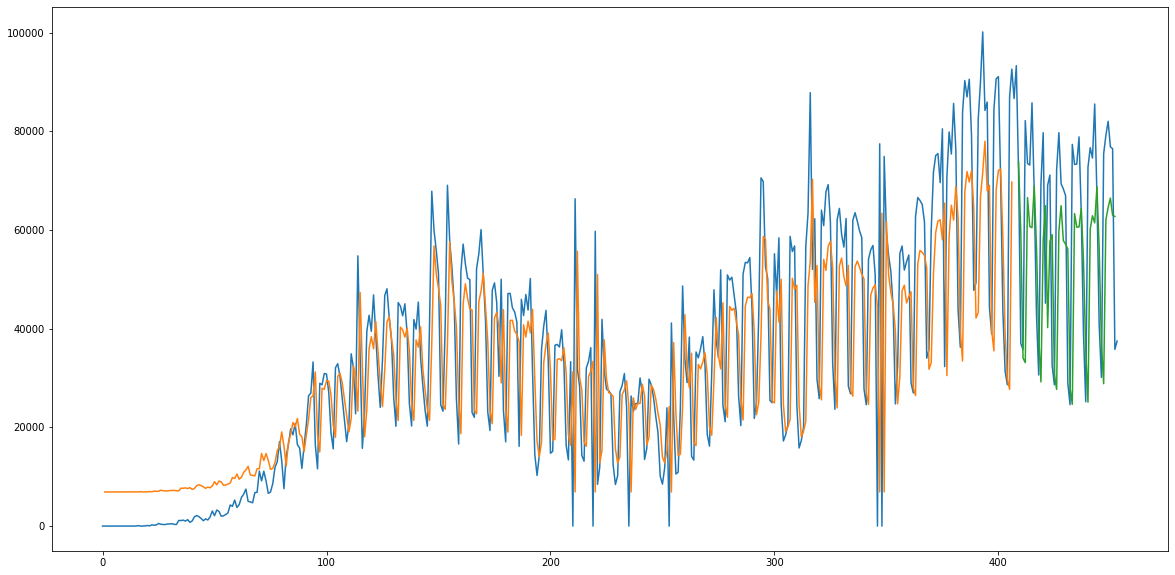

In [112]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [113]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Epoch 1/100
400/400 - 2s - loss: 0.0540
Epoch 2/100
400/400 - 1s - loss: 0.0228
Epoch 3/100
400/400 - 1s - loss: 0.0180
Epoch 4/100
400/400 - 1s - loss: 0.0153
Epoch 5/100
400/400 - 1s - loss: 0.0136
Epoch 6/100
400/400 - 1s - loss: 0.0127
Epoch 7/100
400/400 - 1s - loss: 0.0122
Epoch 8/100
400/400 - 1s - loss: 0.0117
Epoch 9/100
400/400 - 1s - loss: 0.0117
Epoch 10/100
400/400 - 1s - loss: 0.0116
Epoch 11/100
400/400 - 1s - loss: 0.0115
Epoch 12/100
400/400 - 1s - loss: 0.0115
Epoch 13/100
400/400 - 1s - loss: 0.0111
Epoch 14/100
400/400 - 1s - loss: 0.0115
Epoch 15/100
400/400 - 1s - loss: 0.0111
Epoch 16/100
400/400 - 1s - loss: 0.0112
Epoch 17/100
400/400 - 1s - loss: 0.0112
Epoch 18/100
400/400 - 1s - loss: 0.0113
Epoch 19/100
400/400 - 1s - loss: 0.0112
Epoch 20/100
400/400 - 1s - loss: 0.0115
Epoch 21/100
400/400 - 1s - loss: 0.0111
Epoch 22/100
400/400 - 1s - loss: 0.0109
Epoch 23/100
400/400 - 1s - loss: 0.0111
Epoch 24/100
400/400 - 1s - loss: 0.0111
Epoch 25/100
400/400 - 1s

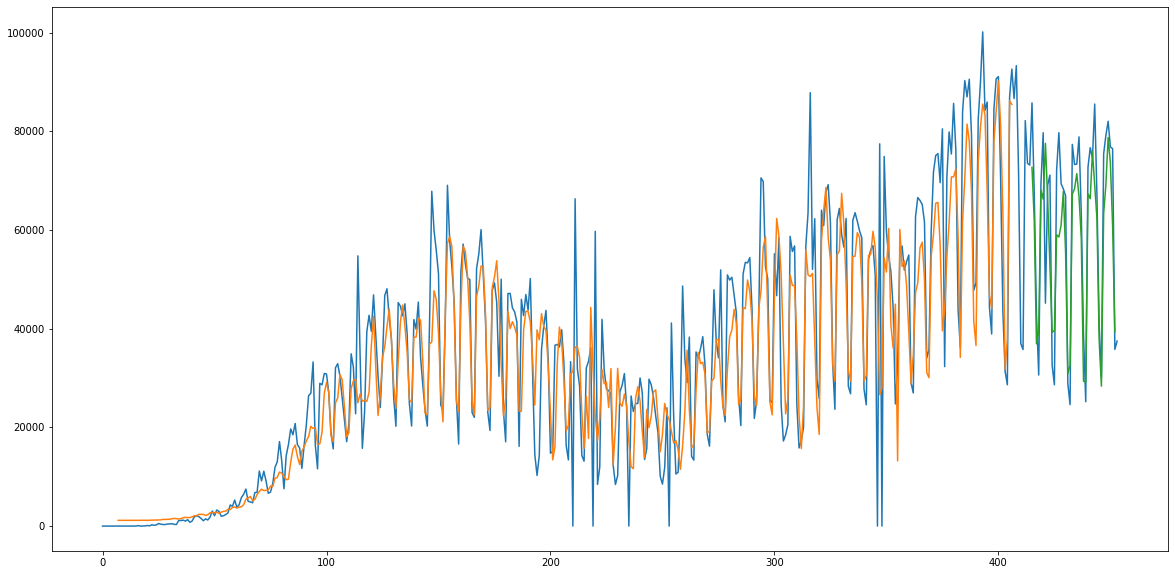

In [114]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#Testes com janela de 7 dias com (6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17 unidades de memória)

In [217]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0595
Epoch 2/100
400/400 - 1s - loss: 0.0230
Epoch 3/100
400/400 - 1s - loss: 0.0169
Epoch 4/100
400/400 - 1s - loss: 0.0143
Epoch 5/100
400/400 - 1s - loss: 0.0132
Epoch 6/100
400/400 - 1s - loss: 0.0127
Epoch 7/100
400/400 - 1s - loss: 0.0123
Epoch 8/100
400/400 - 1s - loss: 0.0123
Epoch 9/100
400/400 - 1s - loss: 0.0116
Epoch 10/100
400/400 - 1s - loss: 0.0120
Epoch 11/100
400/400 - 1s - loss: 0.0121
Epoch 12/100
400/400 - 1s - loss: 0.0115
Epoch 13/100
400/400 - 1s - loss: 0.0117
Epoch 14/100
400/400 - 1s - loss: 0.0117
Epoch 15/100
400/400 - 1s - loss: 0.0116
Epoch 16/100
400/400 - 1s - loss: 0.0115
Epoch 17/100
400/400 - 1s - loss: 0.0115
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0115
Epoch 20/100
400/400 - 1s - loss: 0.0110
Epoch 21/100
400/400 - 1s - loss: 0.0113
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0113
Epoch 24/100
400/400 - 1s - loss: 0.0113
Epoch 25/100
400/400 - 1s

Train Score: 10118.31 RMSE
Test Score: 9929.42 RMSE


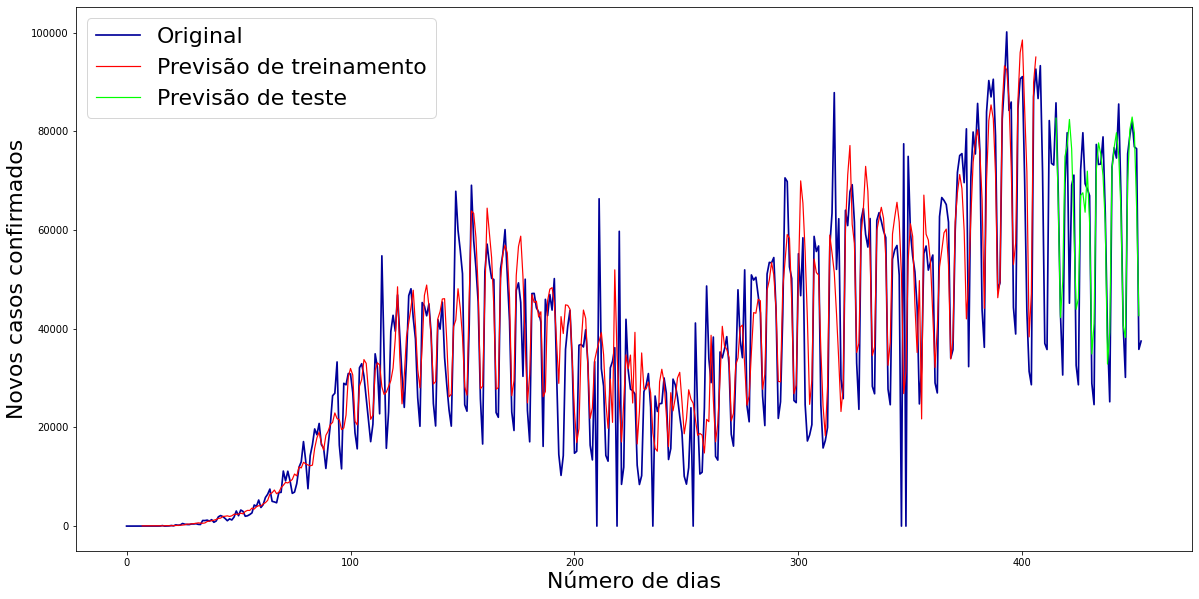

In [116]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Previsão de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Previsão de teste')


plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [117]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0256
Epoch 2/100
400/400 - 1s - loss: 0.0145
Epoch 3/100
400/400 - 1s - loss: 0.0123
Epoch 4/100
400/400 - 1s - loss: 0.0119
Epoch 5/100
400/400 - 1s - loss: 0.0116
Epoch 6/100
400/400 - 1s - loss: 0.0116
Epoch 7/100
400/400 - 1s - loss: 0.0116
Epoch 8/100
400/400 - 1s - loss: 0.0115
Epoch 9/100
400/400 - 1s - loss: 0.0112
Epoch 10/100
400/400 - 1s - loss: 0.0116
Epoch 11/100
400/400 - 1s - loss: 0.0113
Epoch 12/100
400/400 - 1s - loss: 0.0116
Epoch 13/100
400/400 - 1s - loss: 0.0112
Epoch 14/100
400/400 - 1s - loss: 0.0113
Epoch 15/100
400/400 - 1s - loss: 0.0114
Epoch 16/100
400/400 - 1s - loss: 0.0113
Epoch 17/100
400/400 - 1s - loss: 0.0115
Epoch 18/100
400/400 - 1s - loss: 0.0111
Epoch 19/100
400/400 - 1s - loss: 0.0111
Epoch 20/100
400/400 - 1s - loss: 0.0113
Epoch 21/100
400/400 - 1s - loss: 0.0112
Epoch 22/100
400/400 - 1s - loss: 0.0111
Epoch 23/100
400/400 - 1s - loss: 0.0110
Epoch 24/100
400/400 - 1s - loss: 0.0113
Epoch 25/100
400/400 - 1s

Train Score: 10137.73 RMSE
Test Score: 10717.48 RMSE


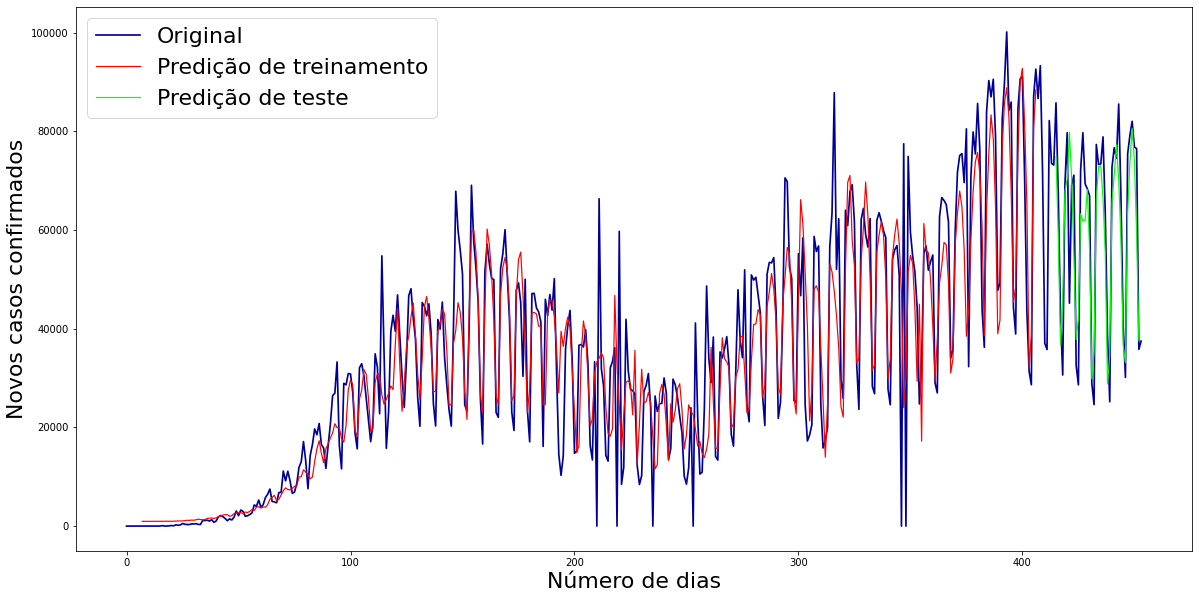

In [118]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')


plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [119]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0349
Epoch 2/100
400/400 - 1s - loss: 0.0141
Epoch 3/100
400/400 - 1s - loss: 0.0129
Epoch 4/100
400/400 - 1s - loss: 0.0125
Epoch 5/100
400/400 - 1s - loss: 0.0119
Epoch 6/100
400/400 - 1s - loss: 0.0117
Epoch 7/100
400/400 - 1s - loss: 0.0118
Epoch 8/100
400/400 - 1s - loss: 0.0116
Epoch 9/100
400/400 - 1s - loss: 0.0115
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0112
Epoch 12/100
400/400 - 1s - loss: 0.0113
Epoch 13/100
400/400 - 1s - loss: 0.0113
Epoch 14/100
400/400 - 1s - loss: 0.0113
Epoch 15/100
400/400 - 1s - loss: 0.0113
Epoch 16/100
400/400 - 1s - loss: 0.0110
Epoch 17/100
400/400 - 1s - loss: 0.0111
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0112
Epoch 20/100
400/400 - 1s - loss: 0.0110
Epoch 21/100
400/400 - 1s - loss: 0.0114
Epoch 22/100
400/400 - 1s - loss: 0.0110
Epoch 23/100
400/400 - 1s - loss: 0.0110
Epoch 24/100
400/400 - 1s - loss: 0.0111
Epoch 25/100
400/400 - 1s

Train Score: 10030.07 RMSE
Test Score: 10417.27 RMSE


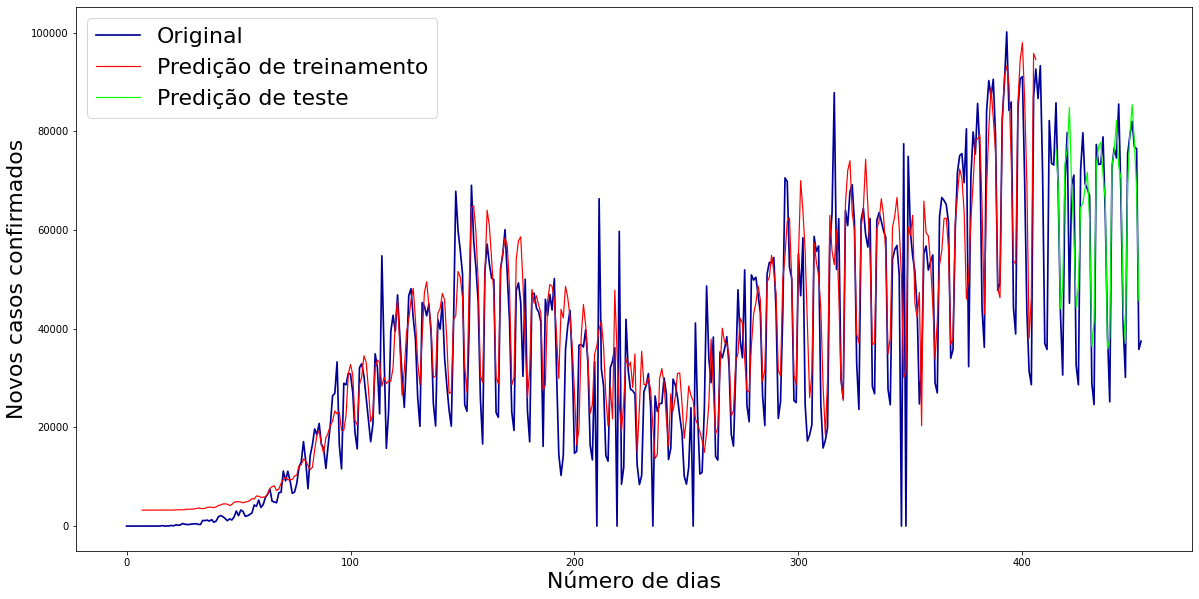

In [120]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [121]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(9, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0393
Epoch 2/100
400/400 - 1s - loss: 0.0156
Epoch 3/100
400/400 - 1s - loss: 0.0134
Epoch 4/100
400/400 - 1s - loss: 0.0127
Epoch 5/100
400/400 - 1s - loss: 0.0126
Epoch 6/100
400/400 - 1s - loss: 0.0123
Epoch 7/100
400/400 - 1s - loss: 0.0120
Epoch 8/100
400/400 - 1s - loss: 0.0121
Epoch 9/100
400/400 - 1s - loss: 0.0116
Epoch 10/100
400/400 - 1s - loss: 0.0117
Epoch 11/100
400/400 - 1s - loss: 0.0118
Epoch 12/100
400/400 - 1s - loss: 0.0118
Epoch 13/100
400/400 - 1s - loss: 0.0117
Epoch 14/100
400/400 - 1s - loss: 0.0117
Epoch 15/100
400/400 - 1s - loss: 0.0117
Epoch 16/100
400/400 - 1s - loss: 0.0115
Epoch 17/100
400/400 - 1s - loss: 0.0116
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0114
Epoch 20/100
400/400 - 1s - loss: 0.0111
Epoch 21/100
400/400 - 1s - loss: 0.0115
Epoch 22/100
400/400 - 1s - loss: 0.0114
Epoch 23/100
400/400 - 1s - loss: 0.0112
Epoch 24/100
400/400 - 1s - loss: 0.0113
Epoch 25/100
400/400 - 1s

Train Score: 10008.11 RMSE
Test Score: 9855.38 RMSE


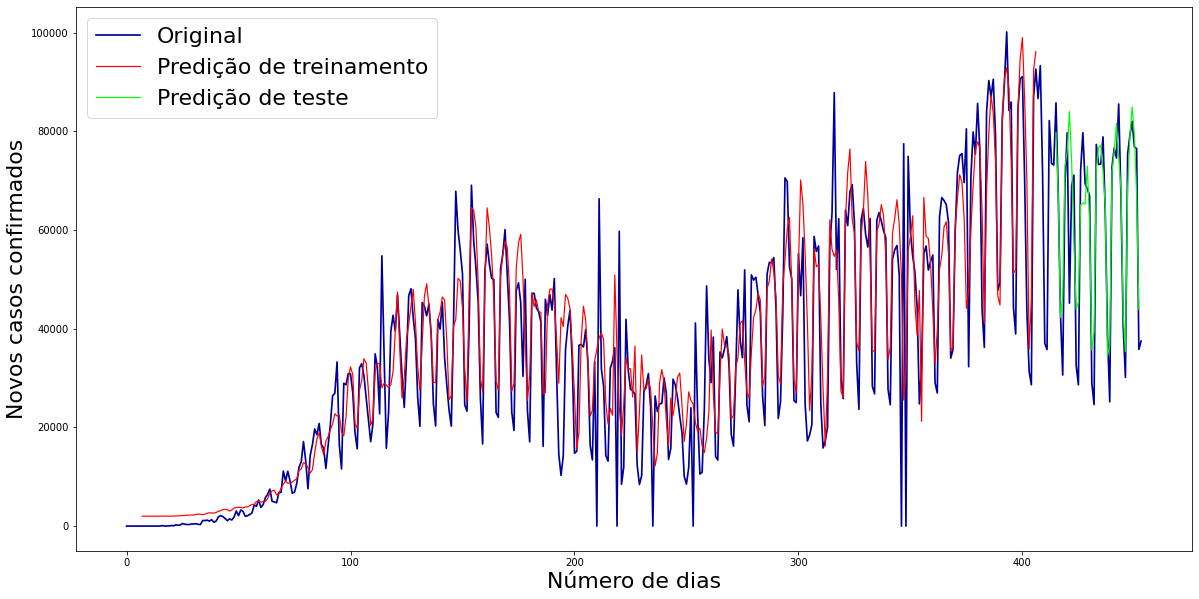

In [122]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [123]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0421
Epoch 2/100
400/400 - 1s - loss: 0.0171
Epoch 3/100
400/400 - 1s - loss: 0.0138
Epoch 4/100
400/400 - 1s - loss: 0.0126
Epoch 5/100
400/400 - 1s - loss: 0.0119
Epoch 6/100
400/400 - 1s - loss: 0.0117
Epoch 7/100
400/400 - 1s - loss: 0.0116
Epoch 8/100
400/400 - 1s - loss: 0.0115
Epoch 9/100
400/400 - 1s - loss: 0.0116
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0112
Epoch 12/100
400/400 - 1s - loss: 0.0114
Epoch 13/100
400/400 - 1s - loss: 0.0115
Epoch 14/100
400/400 - 1s - loss: 0.0114
Epoch 15/100
400/400 - 1s - loss: 0.0115
Epoch 16/100
400/400 - 1s - loss: 0.0115
Epoch 17/100
400/400 - 1s - loss: 0.0114
Epoch 18/100
400/400 - 1s - loss: 0.0113
Epoch 19/100
400/400 - 1s - loss: 0.0115
Epoch 20/100
400/400 - 1s - loss: 0.0113
Epoch 21/100
400/400 - 1s - loss: 0.0115
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0111
Epoch 24/100
400/400 - 1s - loss: 0.0113
Epoch 25/100
400/400 - 1s

Train Score: 9847.32 RMSE
Test Score: 10025.36 RMSE


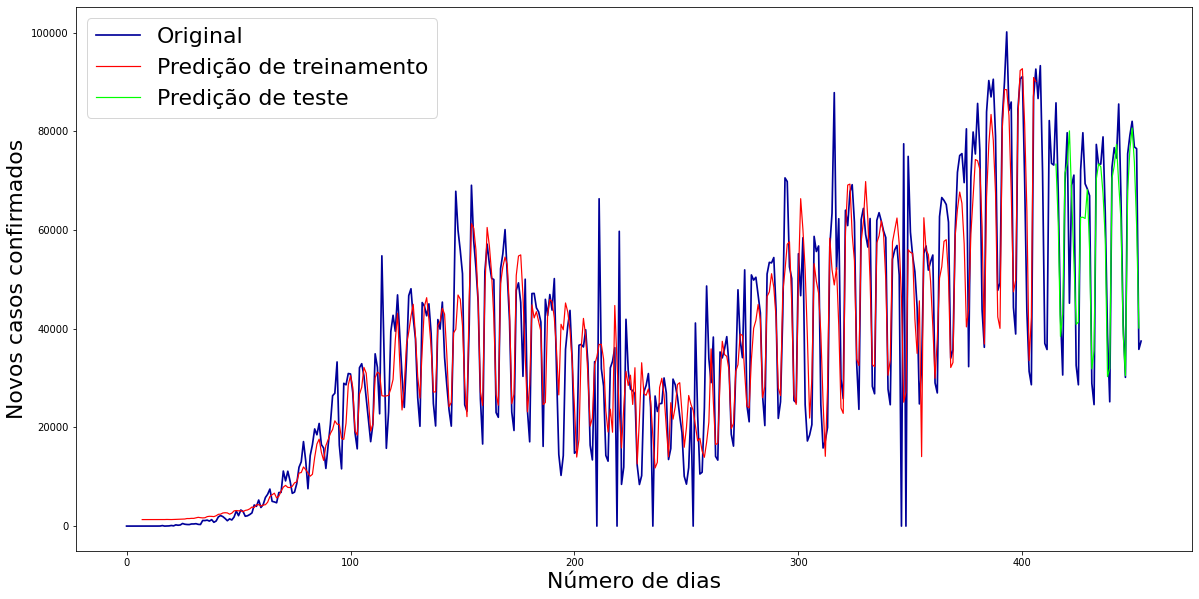

In [124]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [207]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(11, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0332
Epoch 2/100
400/400 - 1s - loss: 0.0149
Epoch 3/100
400/400 - 1s - loss: 0.0126
Epoch 4/100
400/400 - 1s - loss: 0.0120
Epoch 5/100
400/400 - 1s - loss: 0.0118
Epoch 6/100
400/400 - 1s - loss: 0.0118
Epoch 7/100
400/400 - 1s - loss: 0.0117
Epoch 8/100
400/400 - 1s - loss: 0.0118
Epoch 9/100
400/400 - 1s - loss: 0.0114
Epoch 10/100
400/400 - 1s - loss: 0.0117
Epoch 11/100
400/400 - 1s - loss: 0.0118
Epoch 12/100
400/400 - 1s - loss: 0.0115
Epoch 13/100
400/400 - 1s - loss: 0.0113
Epoch 14/100
400/400 - 1s - loss: 0.0114
Epoch 15/100
400/400 - 1s - loss: 0.0114
Epoch 16/100
400/400 - 1s - loss: 0.0113
Epoch 17/100
400/400 - 1s - loss: 0.0112
Epoch 18/100
400/400 - 1s - loss: 0.0113
Epoch 19/100
400/400 - 1s - loss: 0.0115
Epoch 20/100
400/400 - 1s - loss: 0.0114
Epoch 21/100
400/400 - 1s - loss: 0.0116
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0115
Epoch 24/100
400/400 - 1s - loss: 0.0114
Epoch 25/100
400/400 - 1s

Train Score: 9769.43 RMSE
Test Score: 9854.09 RMSE


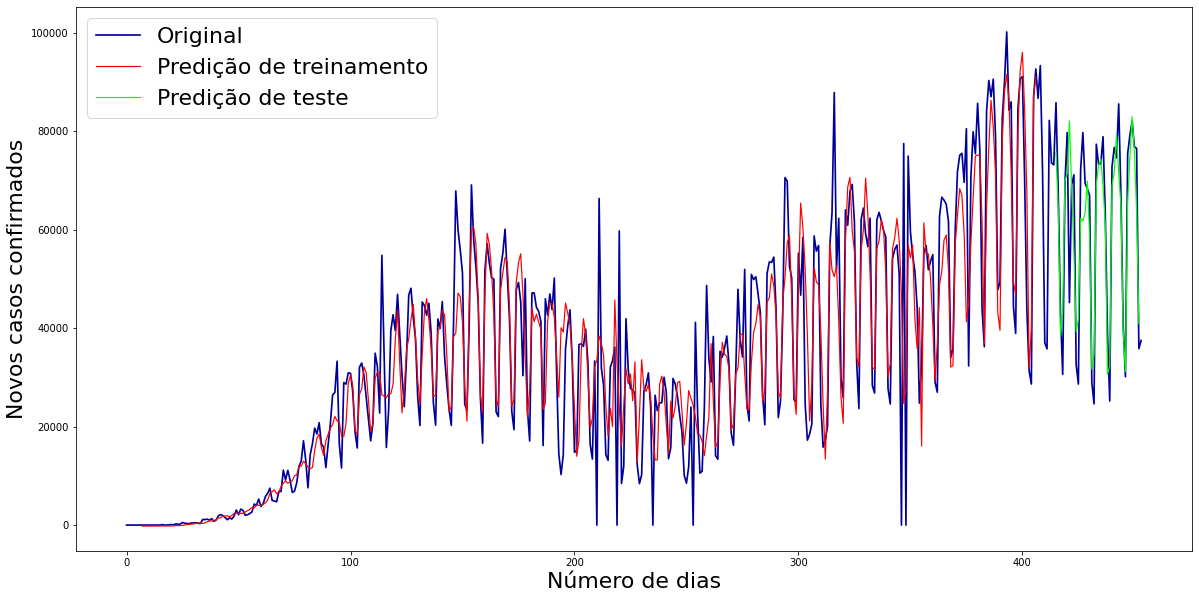

In [208]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [213]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0569
Epoch 2/100
400/400 - 1s - loss: 0.0184
Epoch 3/100
400/400 - 1s - loss: 0.0133
Epoch 4/100
400/400 - 1s - loss: 0.0120
Epoch 5/100
400/400 - 1s - loss: 0.0119
Epoch 6/100
400/400 - 1s - loss: 0.0117
Epoch 7/100
400/400 - 1s - loss: 0.0118
Epoch 8/100
400/400 - 1s - loss: 0.0116
Epoch 9/100
400/400 - 1s - loss: 0.0116
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0117
Epoch 12/100
400/400 - 1s - loss: 0.0112
Epoch 13/100
400/400 - 1s - loss: 0.0114
Epoch 14/100
400/400 - 1s - loss: 0.0119
Epoch 15/100
400/400 - 1s - loss: 0.0112
Epoch 16/100
400/400 - 1s - loss: 0.0116
Epoch 17/100
400/400 - 1s - loss: 0.0113
Epoch 18/100
400/400 - 1s - loss: 0.0113
Epoch 19/100
400/400 - 1s - loss: 0.0112
Epoch 20/100
400/400 - 1s - loss: 0.0112
Epoch 21/100
400/400 - 1s - loss: 0.0113
Epoch 22/100
400/400 - 1s - loss: 0.0114
Epoch 23/100
400/400 - 1s - loss: 0.0111
Epoch 24/100
400/400 - 1s - loss: 0.0112
Epoch 25/100
400/400 - 1s

Train Score: 10102.34 RMSE
Test Score: 10665.34 RMSE


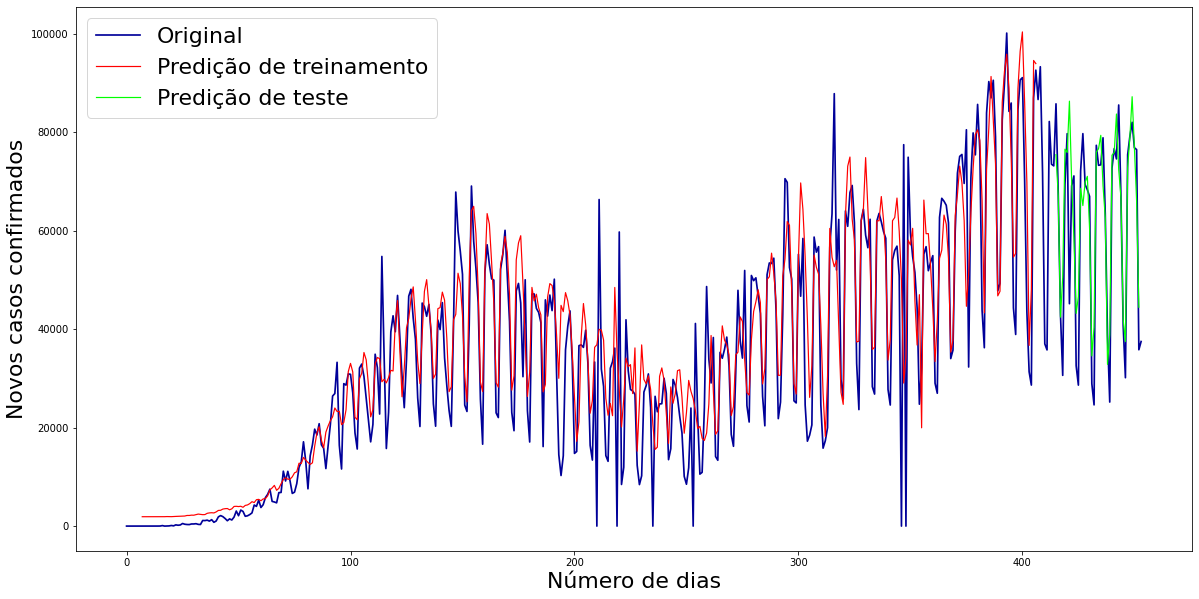

In [214]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [129]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(13, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0280
Epoch 2/100
400/400 - 1s - loss: 0.0136
Epoch 3/100
400/400 - 1s - loss: 0.0121
Epoch 4/100
400/400 - 1s - loss: 0.0117
Epoch 5/100
400/400 - 1s - loss: 0.0117
Epoch 6/100
400/400 - 1s - loss: 0.0116
Epoch 7/100
400/400 - 1s - loss: 0.0114
Epoch 8/100
400/400 - 1s - loss: 0.0117
Epoch 9/100
400/400 - 1s - loss: 0.0117
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0115
Epoch 12/100
400/400 - 1s - loss: 0.0116
Epoch 13/100
400/400 - 1s - loss: 0.0115
Epoch 14/100
400/400 - 1s - loss: 0.0114
Epoch 15/100
400/400 - 1s - loss: 0.0115
Epoch 16/100
400/400 - 1s - loss: 0.0112
Epoch 17/100
400/400 - 1s - loss: 0.0116
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0116
Epoch 20/100
400/400 - 1s - loss: 0.0113
Epoch 21/100
400/400 - 1s - loss: 0.0111
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0114
Epoch 24/100
400/400 - 1s - loss: 0.0112
Epoch 25/100
400/400 - 1s

Train Score: 10196.68 RMSE
Test Score: 10632.62 RMSE


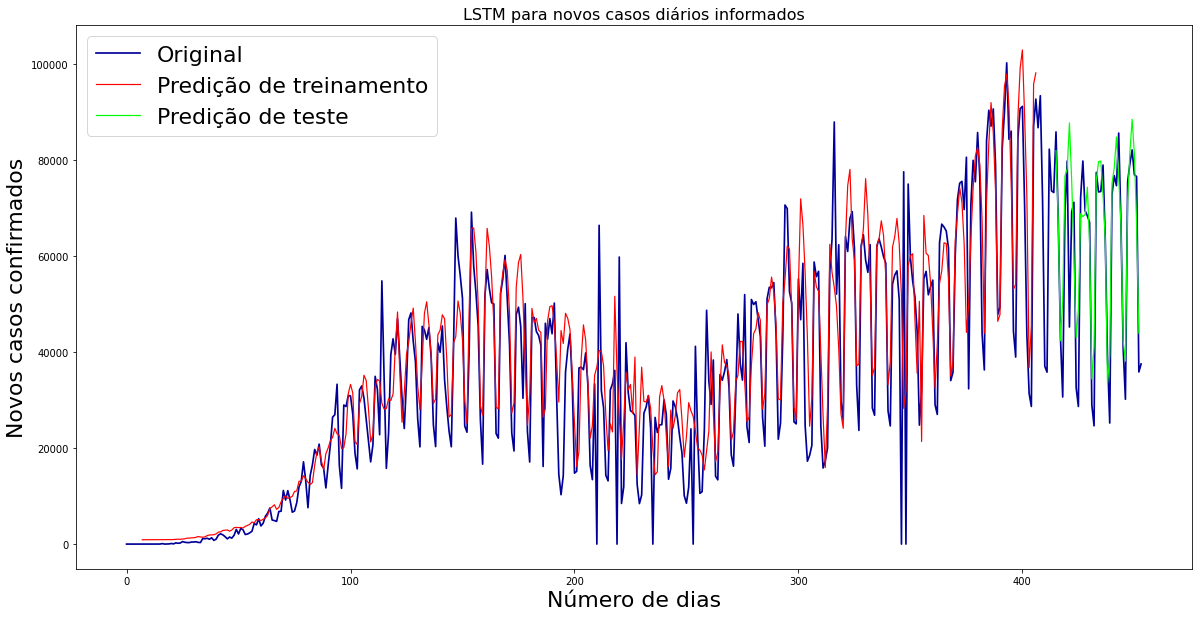

In [130]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')
plt.title('LSTM para novos casos diários informados', fontsize=16)

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [131]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(14, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0307
Epoch 2/100
400/400 - 1s - loss: 0.0178
Epoch 3/100
400/400 - 1s - loss: 0.0138
Epoch 4/100
400/400 - 1s - loss: 0.0123
Epoch 5/100
400/400 - 1s - loss: 0.0120
Epoch 6/100
400/400 - 1s - loss: 0.0117
Epoch 7/100
400/400 - 1s - loss: 0.0120
Epoch 8/100
400/400 - 1s - loss: 0.0119
Epoch 9/100
400/400 - 1s - loss: 0.0113
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0115
Epoch 12/100
400/400 - 1s - loss: 0.0116
Epoch 13/100
400/400 - 1s - loss: 0.0117
Epoch 14/100
400/400 - 1s - loss: 0.0114
Epoch 15/100
400/400 - 1s - loss: 0.0115
Epoch 16/100
400/400 - 1s - loss: 0.0112
Epoch 17/100
400/400 - 1s - loss: 0.0112
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0114
Epoch 20/100
400/400 - 1s - loss: 0.0112
Epoch 21/100
400/400 - 1s - loss: 0.0115
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0113
Epoch 24/100
400/400 - 1s - loss: 0.0112
Epoch 25/100
400/400 - 1s

Train Score: 9631.40 RMSE
Test Score: 10108.51 RMSE


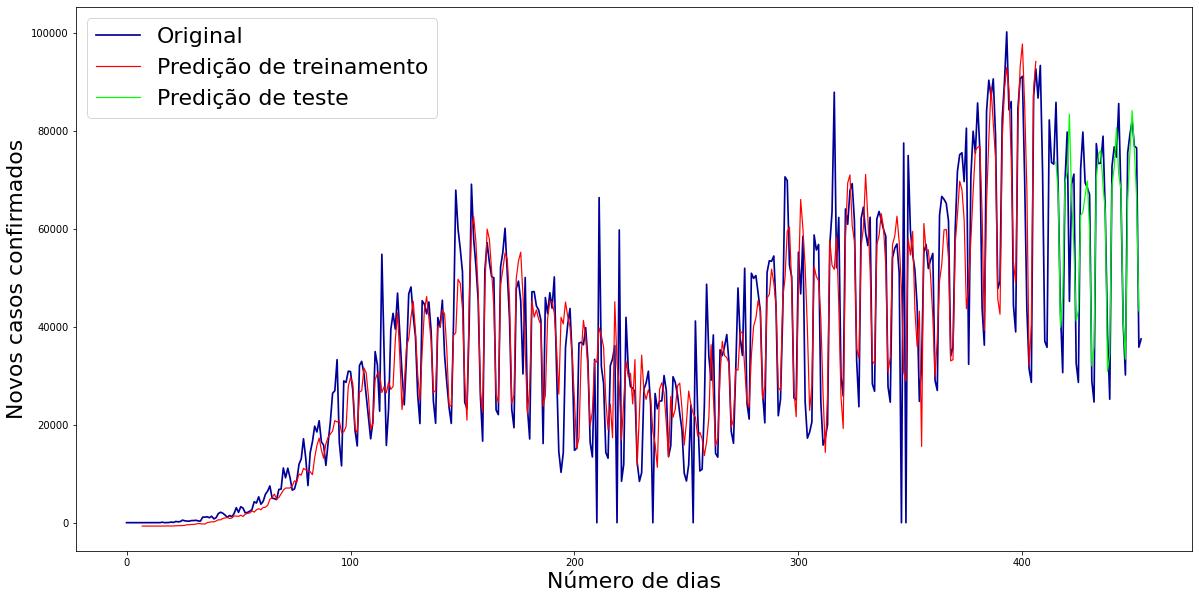

In [132]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [215]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(15, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0258
Epoch 2/100
400/400 - 1s - loss: 0.0143
Epoch 3/100
400/400 - 1s - loss: 0.0128
Epoch 4/100
400/400 - 1s - loss: 0.0119
Epoch 5/100
400/400 - 1s - loss: 0.0121
Epoch 6/100
400/400 - 1s - loss: 0.0119
Epoch 7/100
400/400 - 1s - loss: 0.0122
Epoch 8/100
400/400 - 1s - loss: 0.0117
Epoch 9/100
400/400 - 1s - loss: 0.0118
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0115
Epoch 12/100
400/400 - 1s - loss: 0.0118
Epoch 13/100
400/400 - 1s - loss: 0.0115
Epoch 14/100
400/400 - 1s - loss: 0.0117
Epoch 15/100
400/400 - 1s - loss: 0.0115
Epoch 16/100
400/400 - 1s - loss: 0.0114
Epoch 17/100
400/400 - 1s - loss: 0.0116
Epoch 18/100
400/400 - 1s - loss: 0.0116
Epoch 19/100
400/400 - 1s - loss: 0.0116
Epoch 20/100
400/400 - 1s - loss: 0.0112
Epoch 21/100
400/400 - 1s - loss: 0.0113
Epoch 22/100
400/400 - 1s - loss: 0.0116
Epoch 23/100
400/400 - 1s - loss: 0.0116
Epoch 24/100
400/400 - 1s - loss: 0.0115
Epoch 25/100
400/400 - 1s

Train Score: 9857.83 RMSE
Test Score: 10135.12 RMSE


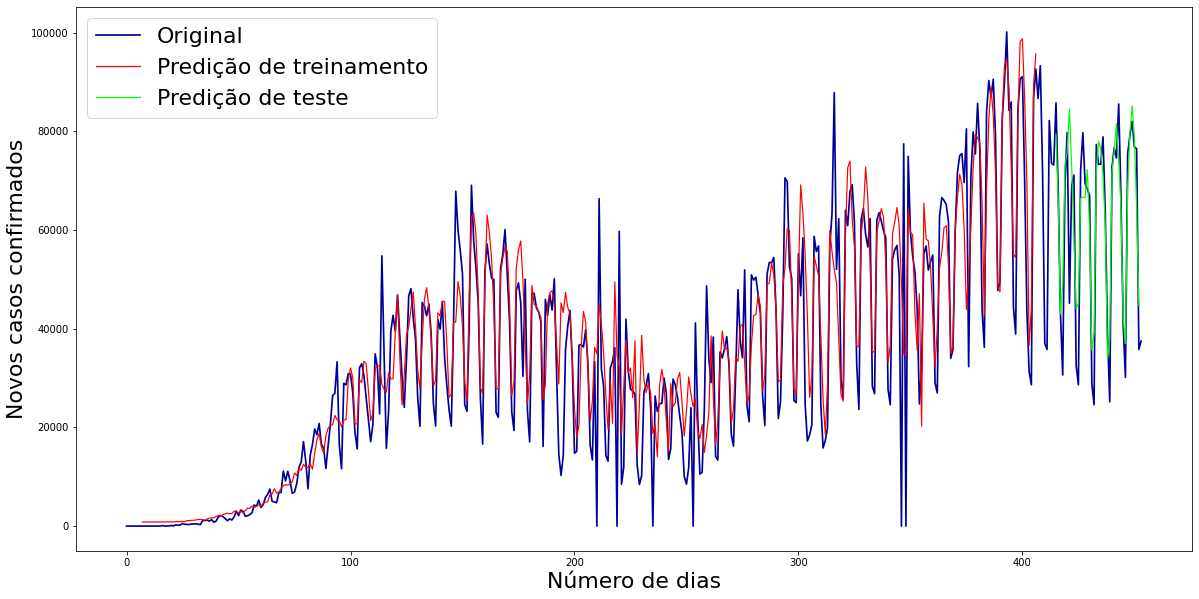

In [216]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [135]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(16, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0517
Epoch 2/100
400/400 - 1s - loss: 0.0177
Epoch 3/100
400/400 - 1s - loss: 0.0143
Epoch 4/100
400/400 - 1s - loss: 0.0127
Epoch 5/100
400/400 - 1s - loss: 0.0124
Epoch 6/100
400/400 - 1s - loss: 0.0120
Epoch 7/100
400/400 - 1s - loss: 0.0119
Epoch 8/100
400/400 - 1s - loss: 0.0116
Epoch 9/100
400/400 - 1s - loss: 0.0118
Epoch 10/100
400/400 - 1s - loss: 0.0117
Epoch 11/100
400/400 - 1s - loss: 0.0116
Epoch 12/100
400/400 - 1s - loss: 0.0112
Epoch 13/100
400/400 - 1s - loss: 0.0120
Epoch 14/100
400/400 - 1s - loss: 0.0115
Epoch 15/100
400/400 - 1s - loss: 0.0114
Epoch 16/100
400/400 - 1s - loss: 0.0115
Epoch 17/100
400/400 - 1s - loss: 0.0113
Epoch 18/100
400/400 - 1s - loss: 0.0115
Epoch 19/100
400/400 - 1s - loss: 0.0113
Epoch 20/100
400/400 - 1s - loss: 0.0117
Epoch 21/100
400/400 - 1s - loss: 0.0115
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0114
Epoch 24/100
400/400 - 1s - loss: 0.0114
Epoch 25/100
400/400 - 1s

Train Score: 9836.84 RMSE
Test Score: 10308.69 RMSE


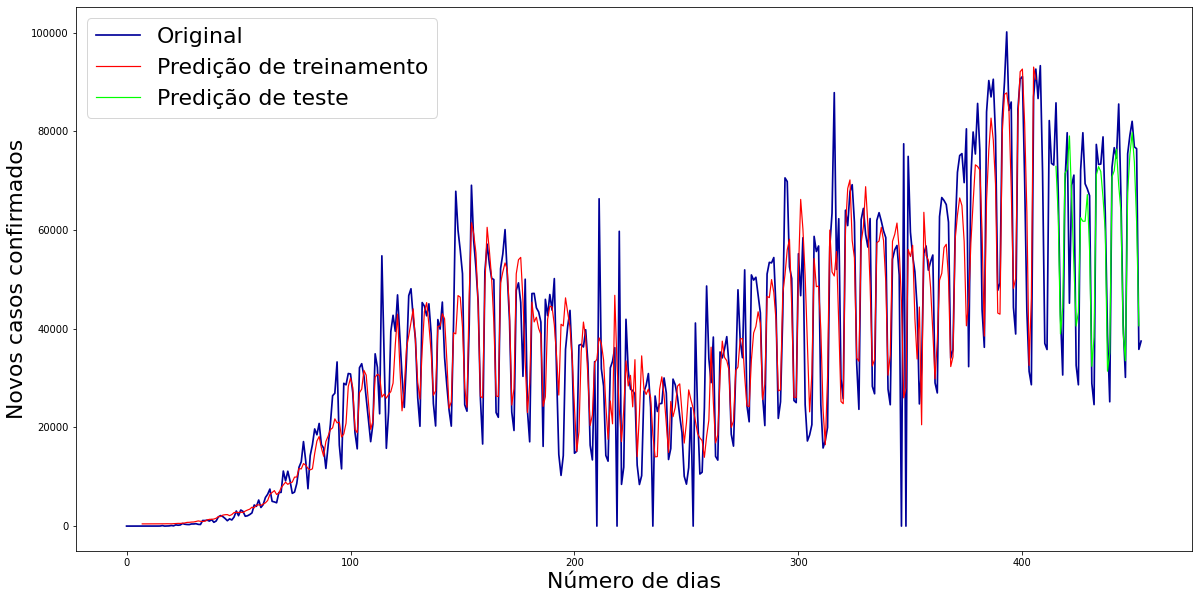

In [136]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [137]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(17, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0350
Epoch 2/100
400/400 - 1s - loss: 0.0156
Epoch 3/100
400/400 - 1s - loss: 0.0138
Epoch 4/100
400/400 - 1s - loss: 0.0127
Epoch 5/100
400/400 - 1s - loss: 0.0124
Epoch 6/100
400/400 - 1s - loss: 0.0123
Epoch 7/100
400/400 - 1s - loss: 0.0119
Epoch 8/100
400/400 - 1s - loss: 0.0124
Epoch 9/100
400/400 - 1s - loss: 0.0117
Epoch 10/100
400/400 - 1s - loss: 0.0115
Epoch 11/100
400/400 - 1s - loss: 0.0116
Epoch 12/100
400/400 - 1s - loss: 0.0119
Epoch 13/100
400/400 - 1s - loss: 0.0115
Epoch 14/100
400/400 - 1s - loss: 0.0116
Epoch 15/100
400/400 - 1s - loss: 0.0117
Epoch 16/100
400/400 - 1s - loss: 0.0116
Epoch 17/100
400/400 - 1s - loss: 0.0115
Epoch 18/100
400/400 - 1s - loss: 0.0116
Epoch 19/100
400/400 - 1s - loss: 0.0116
Epoch 20/100
400/400 - 1s - loss: 0.0115
Epoch 21/100
400/400 - 1s - loss: 0.0112
Epoch 22/100
400/400 - 1s - loss: 0.0113
Epoch 23/100
400/400 - 1s - loss: 0.0115
Epoch 24/100
400/400 - 1s - loss: 0.0115
Epoch 25/100
400/400 - 1s

Train Score: 10092.70 RMSE
Test Score: 10289.15 RMSE


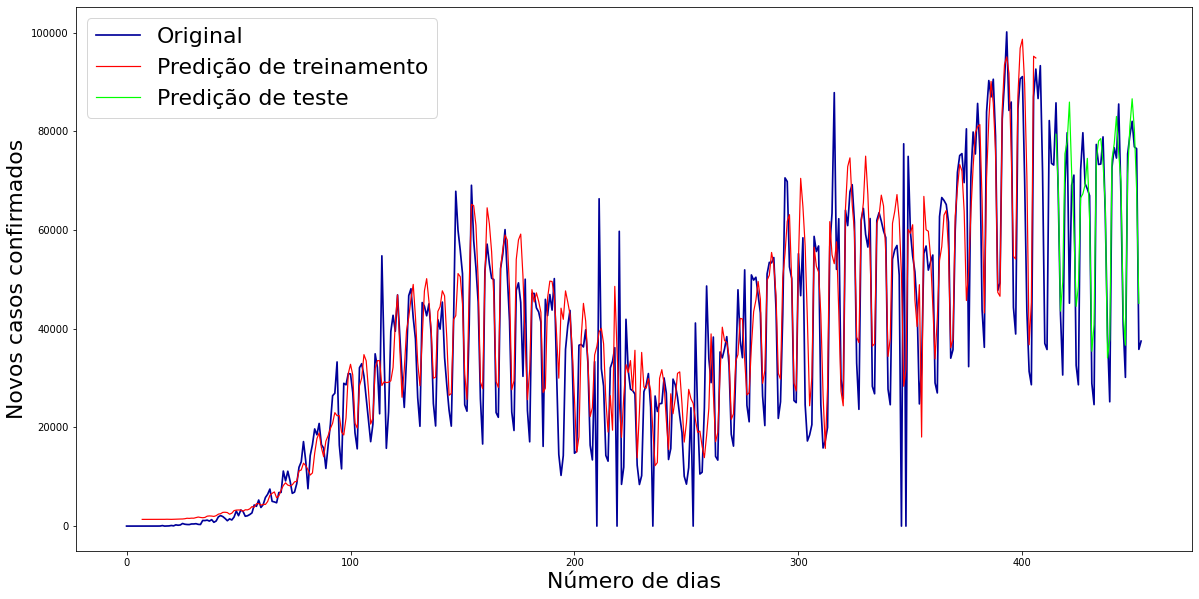

In [138]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [139]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(18, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
400/400 - 2s - loss: 0.0235
Epoch 2/100
400/400 - 1s - loss: 0.0153
Epoch 3/100
400/400 - 1s - loss: 0.0128
Epoch 4/100
400/400 - 1s - loss: 0.0119
Epoch 5/100
400/400 - 1s - loss: 0.0118
Epoch 6/100
400/400 - 1s - loss: 0.0120
Epoch 7/100
400/400 - 1s - loss: 0.0113
Epoch 8/100
400/400 - 1s - loss: 0.0117
Epoch 9/100
400/400 - 1s - loss: 0.0117
Epoch 10/100
400/400 - 1s - loss: 0.0116
Epoch 11/100
400/400 - 1s - loss: 0.0118
Epoch 12/100
400/400 - 1s - loss: 0.0117
Epoch 13/100
400/400 - 1s - loss: 0.0115
Epoch 14/100
400/400 - 1s - loss: 0.0117
Epoch 15/100
400/400 - 1s - loss: 0.0116
Epoch 16/100
400/400 - 1s - loss: 0.0112
Epoch 17/100
400/400 - 1s - loss: 0.0114
Epoch 18/100
400/400 - 1s - loss: 0.0114
Epoch 19/100
400/400 - 1s - loss: 0.0115
Epoch 20/100
400/400 - 1s - loss: 0.0117
Epoch 21/100
400/400 - 1s - loss: 0.0117
Epoch 22/100
400/400 - 1s - loss: 0.0115
Epoch 23/100
400/400 - 1s - loss: 0.0114
Epoch 24/100
400/400 - 1s - loss: 0.0111
Epoch 25/100
400/400 - 1s

Train Score: 10315.32 RMSE
Test Score: 11079.30 RMSE


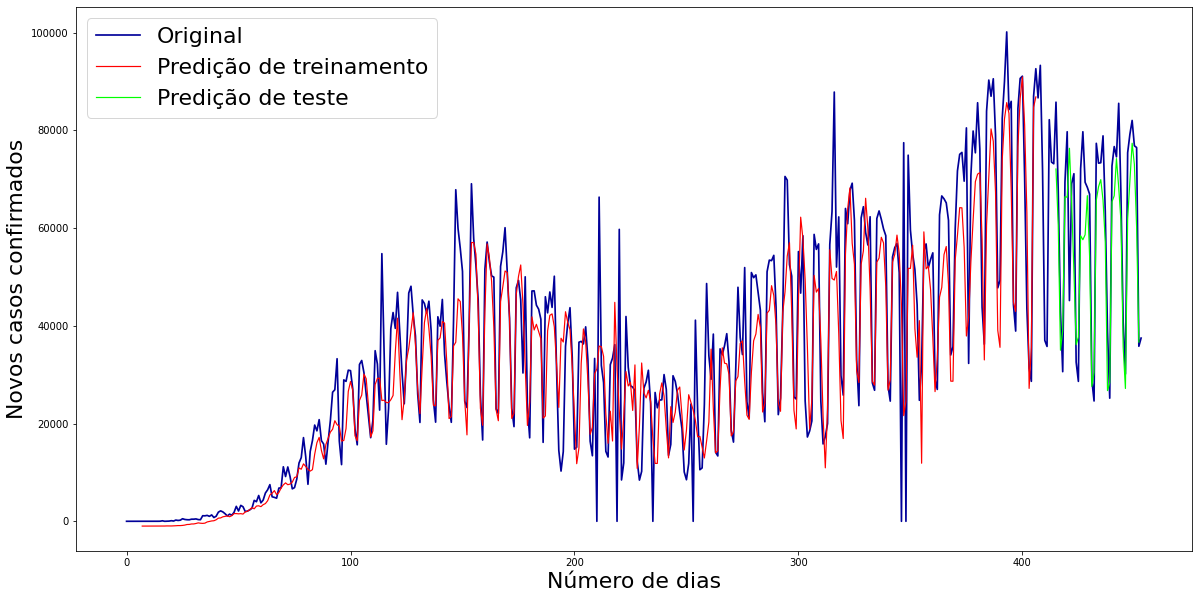

In [140]:
plt.figure(figsize=(20,10))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

#Testes com janela de 21 dias com (6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17 unidades de memória)

In [173]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0284
Epoch 2/100
386/386 - 1s - loss: 0.0173
Epoch 3/100
386/386 - 1s - loss: 0.0143
Epoch 4/100
386/386 - 1s - loss: 0.0130
Epoch 5/100
386/386 - 1s - loss: 0.0127
Epoch 6/100
386/386 - 1s - loss: 0.0126
Epoch 7/100
386/386 - 1s - loss: 0.0119
Epoch 8/100
386/386 - 1s - loss: 0.0114
Epoch 9/100
386/386 - 1s - loss: 0.0113
Epoch 10/100
386/386 - 1s - loss: 0.0111
Epoch 11/100
386/386 - 1s - loss: 0.0110
Epoch 12/100
386/386 - 1s - loss: 0.0110
Epoch 13/100
386/386 - 1s - loss: 0.0110
Epoch 14/100
386/386 - 1s - loss: 0.0111
Epoch 15/100
386/386 - 1s - loss: 0.0111
Epoch 16/100
386/386 - 1s - loss: 0.0107
Epoch 17/100
386/386 - 1s - loss: 0.0106
Epoch 18/100
386/386 - 1s - loss: 0.0106
Epoch 19/100
386/386 - 1s - loss: 0.0109
Epoch 20/100
386/386 - 1s - loss: 0.0103
Epoch 21/100
386/386 - 1s - loss: 0.0107
Epoch 22/100
386/386 - 1s - loss: 0.0104
Epoch 23/100
386/386 - 1s - loss: 0.0106
Epoch 24/100
386/386 - 1s - loss: 0.0104
Epoch 25/100
386/386 - 1s

Train Score: 10976.56 RMSE
Test Score: 9391.53 RMSE


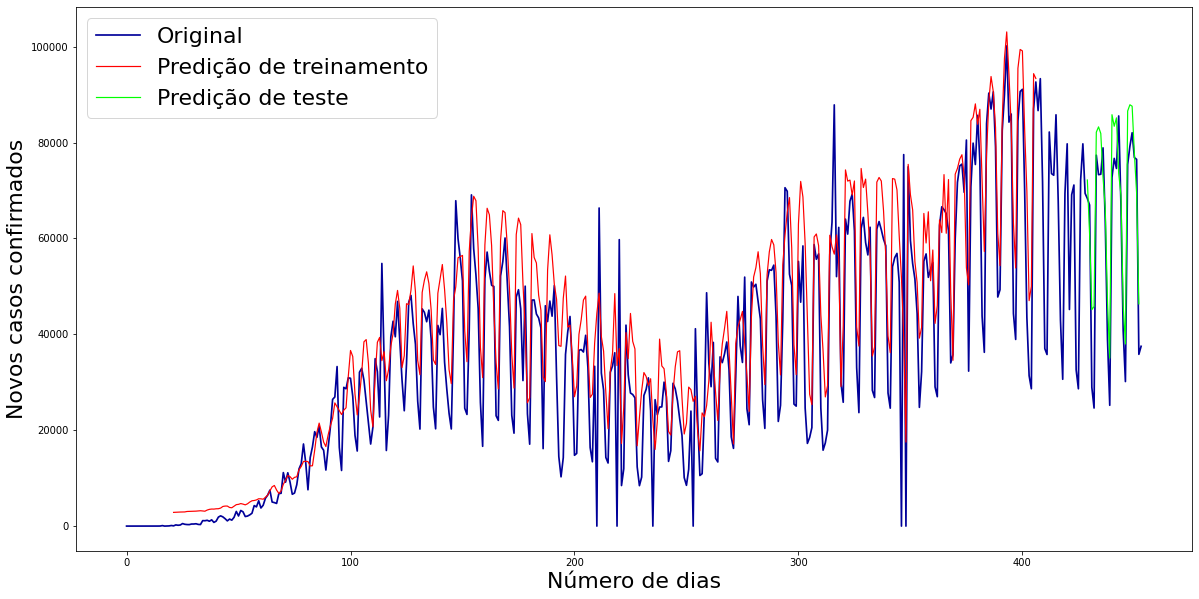

In [174]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [175]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0398
Epoch 2/100
386/386 - 1s - loss: 0.0162
Epoch 3/100
386/386 - 1s - loss: 0.0144
Epoch 4/100
386/386 - 1s - loss: 0.0131
Epoch 5/100
386/386 - 1s - loss: 0.0127
Epoch 6/100
386/386 - 1s - loss: 0.0123
Epoch 7/100
386/386 - 1s - loss: 0.0117
Epoch 8/100
386/386 - 1s - loss: 0.0116
Epoch 9/100
386/386 - 1s - loss: 0.0113
Epoch 10/100
386/386 - 1s - loss: 0.0114
Epoch 11/100
386/386 - 1s - loss: 0.0110
Epoch 12/100
386/386 - 1s - loss: 0.0112
Epoch 13/100
386/386 - 1s - loss: 0.0107
Epoch 14/100
386/386 - 1s - loss: 0.0109
Epoch 15/100
386/386 - 1s - loss: 0.0108
Epoch 16/100
386/386 - 1s - loss: 0.0106
Epoch 17/100
386/386 - 1s - loss: 0.0108
Epoch 18/100
386/386 - 1s - loss: 0.0105
Epoch 19/100
386/386 - 1s - loss: 0.0103
Epoch 20/100
386/386 - 1s - loss: 0.0103
Epoch 21/100
386/386 - 1s - loss: 0.0105
Epoch 22/100
386/386 - 1s - loss: 0.0104
Epoch 23/100
386/386 - 1s - loss: 0.0104
Epoch 24/100
386/386 - 1s - loss: 0.0103
Epoch 25/100
386/386 - 1s

Train Score: 9050.17 RMSE
Test Score: 6833.16 RMSE


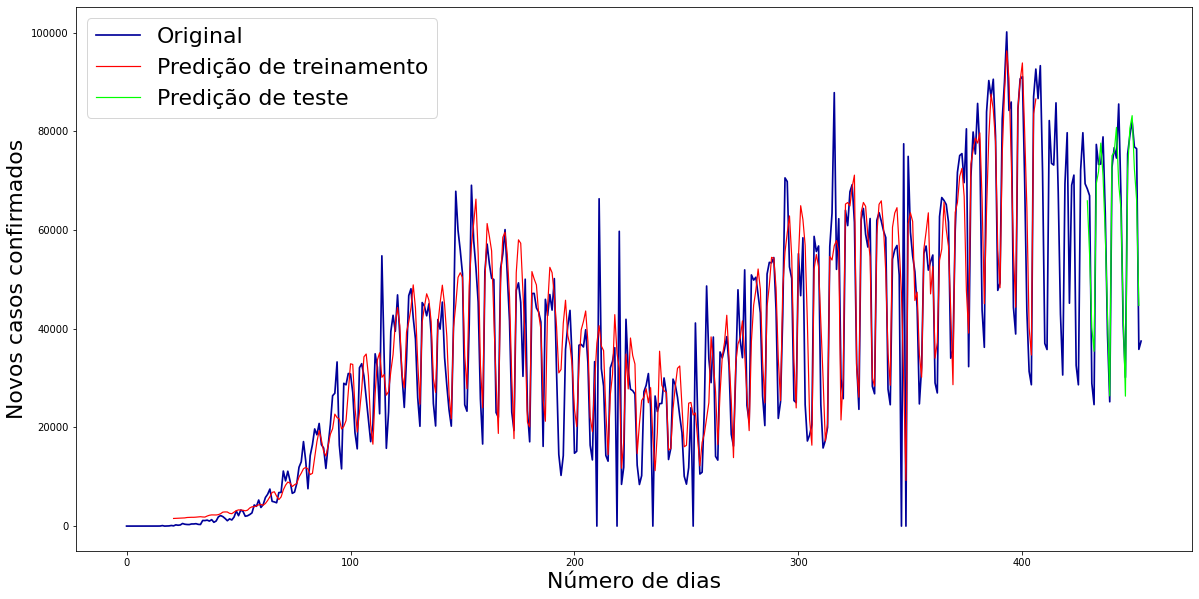

In [176]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [177]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0341
Epoch 2/100
386/386 - 1s - loss: 0.0161
Epoch 3/100
386/386 - 1s - loss: 0.0137
Epoch 4/100
386/386 - 1s - loss: 0.0119
Epoch 5/100
386/386 - 1s - loss: 0.0118
Epoch 6/100
386/386 - 1s - loss: 0.0115
Epoch 7/100
386/386 - 1s - loss: 0.0112
Epoch 8/100
386/386 - 1s - loss: 0.0110
Epoch 9/100
386/386 - 1s - loss: 0.0110
Epoch 10/100
386/386 - 1s - loss: 0.0105
Epoch 11/100
386/386 - 1s - loss: 0.0106
Epoch 12/100
386/386 - 1s - loss: 0.0106
Epoch 13/100
386/386 - 1s - loss: 0.0108
Epoch 14/100
386/386 - 1s - loss: 0.0108
Epoch 15/100
386/386 - 1s - loss: 0.0104
Epoch 16/100
386/386 - 1s - loss: 0.0106
Epoch 17/100
386/386 - 1s - loss: 0.0101
Epoch 18/100
386/386 - 1s - loss: 0.0104
Epoch 19/100
386/386 - 1s - loss: 0.0102
Epoch 20/100
386/386 - 1s - loss: 0.0103
Epoch 21/100
386/386 - 1s - loss: 0.0105
Epoch 22/100
386/386 - 1s - loss: 0.0104
Epoch 23/100
386/386 - 1s - loss: 0.0101
Epoch 24/100
386/386 - 1s - loss: 0.0101
Epoch 25/100
386/386 - 1s

Train Score: 8689.56 RMSE
Test Score: 7417.04 RMSE


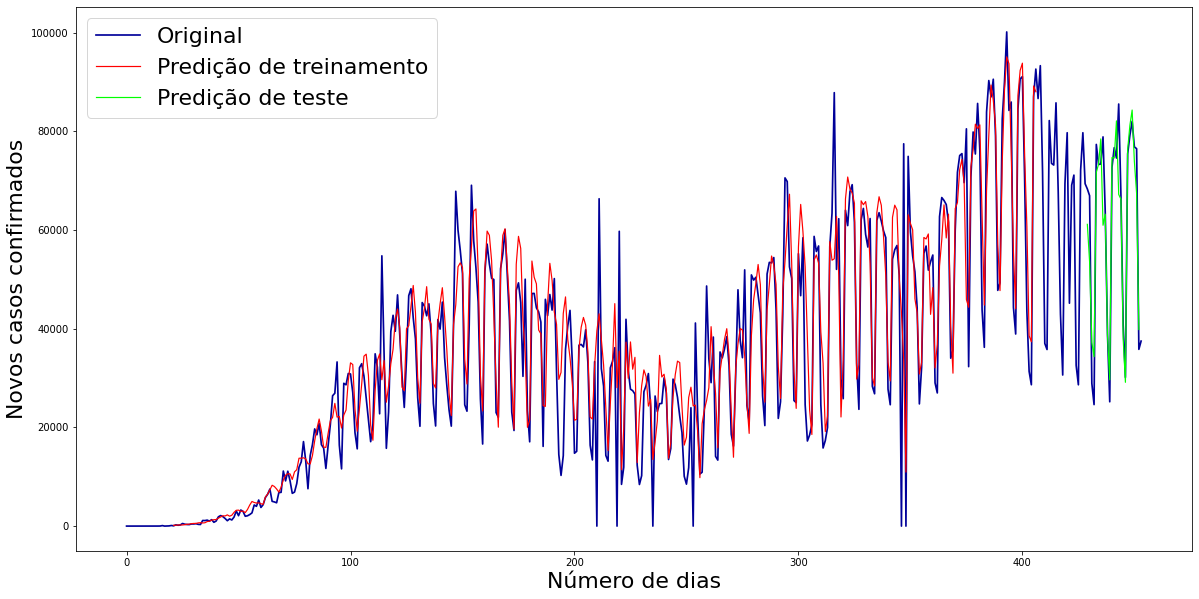

In [178]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [179]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(9, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0309
Epoch 2/100
386/386 - 1s - loss: 0.0183
Epoch 3/100
386/386 - 1s - loss: 0.0140
Epoch 4/100
386/386 - 1s - loss: 0.0126
Epoch 5/100
386/386 - 1s - loss: 0.0124
Epoch 6/100
386/386 - 1s - loss: 0.0118
Epoch 7/100
386/386 - 1s - loss: 0.0115
Epoch 8/100
386/386 - 1s - loss: 0.0114
Epoch 9/100
386/386 - 1s - loss: 0.0116
Epoch 10/100
386/386 - 1s - loss: 0.0115
Epoch 11/100
386/386 - 1s - loss: 0.0110
Epoch 12/100
386/386 - 1s - loss: 0.0112
Epoch 13/100
386/386 - 1s - loss: 0.0109
Epoch 14/100
386/386 - 1s - loss: 0.0112
Epoch 15/100
386/386 - 1s - loss: 0.0109
Epoch 16/100
386/386 - 1s - loss: 0.0107
Epoch 17/100
386/386 - 1s - loss: 0.0109
Epoch 18/100
386/386 - 1s - loss: 0.0106
Epoch 19/100
386/386 - 1s - loss: 0.0103
Epoch 20/100
386/386 - 1s - loss: 0.0104
Epoch 21/100
386/386 - 1s - loss: 0.0105
Epoch 22/100
386/386 - 1s - loss: 0.0105
Epoch 23/100
386/386 - 1s - loss: 0.0103
Epoch 24/100
386/386 - 1s - loss: 0.0106
Epoch 25/100
386/386 - 1s

Train Score: 8957.38 RMSE
Test Score: 7188.35 RMSE


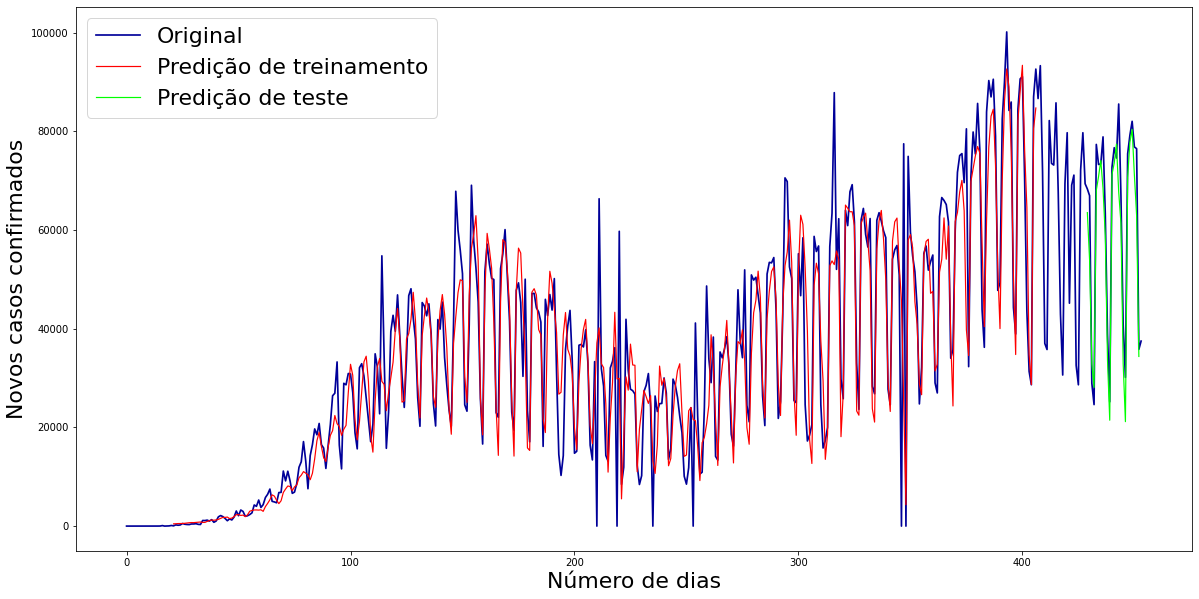

In [180]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [181]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0236
Epoch 2/100
386/386 - 1s - loss: 0.0143
Epoch 3/100
386/386 - 1s - loss: 0.0132
Epoch 4/100
386/386 - 1s - loss: 0.0122
Epoch 5/100
386/386 - 1s - loss: 0.0119
Epoch 6/100
386/386 - 1s - loss: 0.0116
Epoch 7/100
386/386 - 1s - loss: 0.0116
Epoch 8/100
386/386 - 1s - loss: 0.0114
Epoch 9/100
386/386 - 1s - loss: 0.0111
Epoch 10/100
386/386 - 1s - loss: 0.0110
Epoch 11/100
386/386 - 1s - loss: 0.0110
Epoch 12/100
386/386 - 1s - loss: 0.0111
Epoch 13/100
386/386 - 1s - loss: 0.0111
Epoch 14/100
386/386 - 1s - loss: 0.0113
Epoch 15/100
386/386 - 1s - loss: 0.0109
Epoch 16/100
386/386 - 1s - loss: 0.0107
Epoch 17/100
386/386 - 1s - loss: 0.0108
Epoch 18/100
386/386 - 1s - loss: 0.0110
Epoch 19/100
386/386 - 1s - loss: 0.0106
Epoch 20/100
386/386 - 1s - loss: 0.0106
Epoch 21/100
386/386 - 1s - loss: 0.0105
Epoch 22/100
386/386 - 1s - loss: 0.0104
Epoch 23/100
386/386 - 1s - loss: 0.0105
Epoch 24/100
386/386 - 1s - loss: 0.0107
Epoch 25/100
386/386 - 1s

Train Score: 8821.88 RMSE
Test Score: 10942.93 RMSE


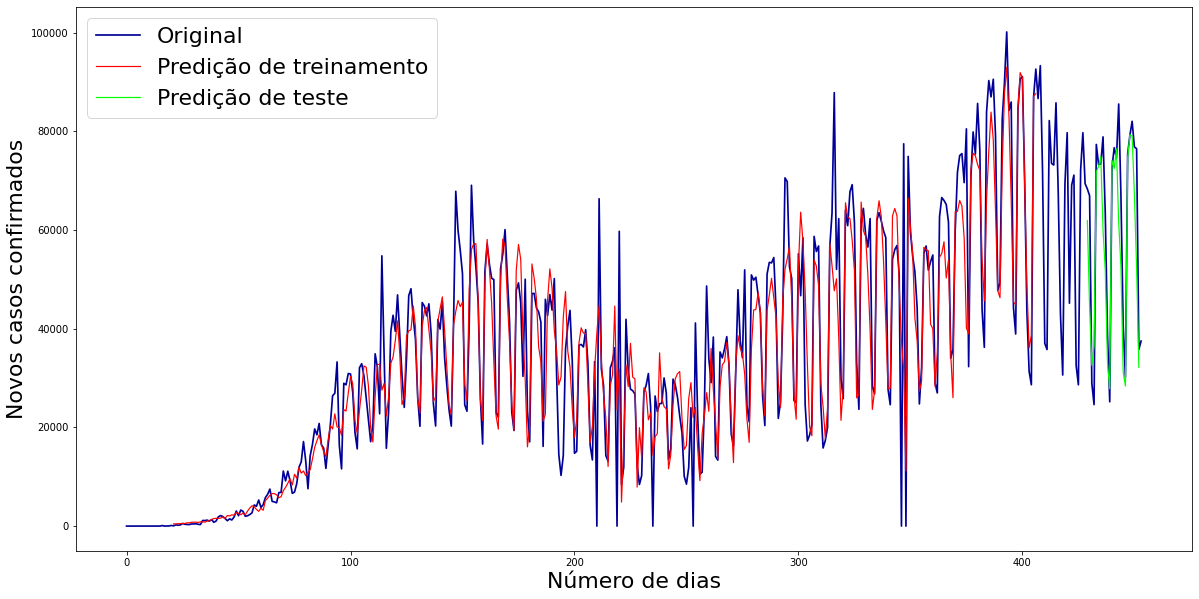

In [182]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [183]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(11, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0211
Epoch 2/100
386/386 - 1s - loss: 0.0125
Epoch 3/100
386/386 - 1s - loss: 0.0119
Epoch 4/100
386/386 - 1s - loss: 0.0122
Epoch 5/100
386/386 - 1s - loss: 0.0114
Epoch 6/100
386/386 - 1s - loss: 0.0112
Epoch 7/100
386/386 - 1s - loss: 0.0124
Epoch 8/100
386/386 - 1s - loss: 0.0111
Epoch 9/100
386/386 - 1s - loss: 0.0108
Epoch 10/100
386/386 - 1s - loss: 0.0111
Epoch 11/100
386/386 - 1s - loss: 0.0109
Epoch 12/100
386/386 - 1s - loss: 0.0112
Epoch 13/100
386/386 - 1s - loss: 0.0106
Epoch 14/100
386/386 - 1s - loss: 0.0107
Epoch 15/100
386/386 - 1s - loss: 0.0108
Epoch 16/100
386/386 - 1s - loss: 0.0109
Epoch 17/100
386/386 - 1s - loss: 0.0105
Epoch 18/100
386/386 - 1s - loss: 0.0102
Epoch 19/100
386/386 - 1s - loss: 0.0103
Epoch 20/100
386/386 - 1s - loss: 0.0102
Epoch 21/100
386/386 - 1s - loss: 0.0104
Epoch 22/100
386/386 - 1s - loss: 0.0102
Epoch 23/100
386/386 - 1s - loss: 0.0104
Epoch 24/100
386/386 - 1s - loss: 0.0106
Epoch 25/100
386/386 - 1s

Train Score: 8815.35 RMSE
Test Score: 9700.13 RMSE


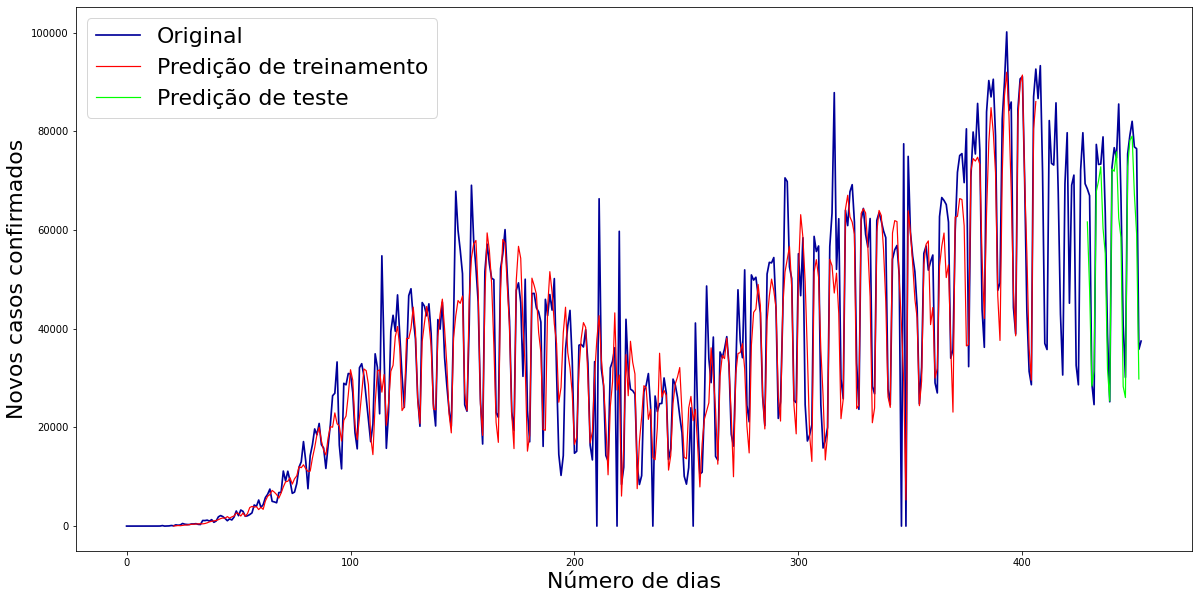

In [184]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [185]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0363
Epoch 2/100
386/386 - 1s - loss: 0.0153
Epoch 3/100
386/386 - 1s - loss: 0.0134
Epoch 4/100
386/386 - 1s - loss: 0.0131
Epoch 5/100
386/386 - 1s - loss: 0.0123
Epoch 6/100
386/386 - 1s - loss: 0.0119
Epoch 7/100
386/386 - 1s - loss: 0.0111
Epoch 8/100
386/386 - 1s - loss: 0.0115
Epoch 9/100
386/386 - 1s - loss: 0.0114
Epoch 10/100
386/386 - 1s - loss: 0.0115
Epoch 11/100
386/386 - 1s - loss: 0.0111
Epoch 12/100
386/386 - 1s - loss: 0.0110
Epoch 13/100
386/386 - 1s - loss: 0.0107
Epoch 14/100
386/386 - 1s - loss: 0.0110
Epoch 15/100
386/386 - 1s - loss: 0.0107
Epoch 16/100
386/386 - 1s - loss: 0.0103
Epoch 17/100
386/386 - 1s - loss: 0.0105
Epoch 18/100
386/386 - 1s - loss: 0.0108
Epoch 19/100
386/386 - 1s - loss: 0.0105
Epoch 20/100
386/386 - 1s - loss: 0.0104
Epoch 21/100
386/386 - 1s - loss: 0.0103
Epoch 22/100
386/386 - 1s - loss: 0.0101
Epoch 23/100
386/386 - 1s - loss: 0.0102
Epoch 24/100
386/386 - 1s - loss: 0.0100
Epoch 25/100
386/386 - 1s

Train Score: 8198.42 RMSE
Test Score: 8234.70 RMSE


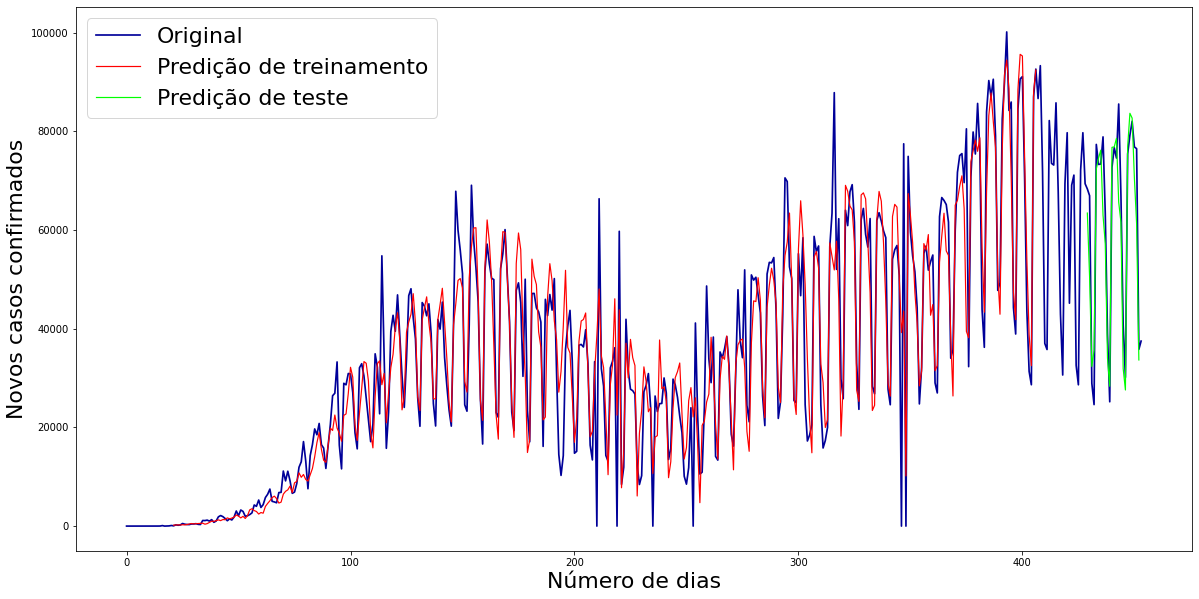

In [186]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [222]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(13, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0348
Epoch 2/100
386/386 - 1s - loss: 0.0153
Epoch 3/100
386/386 - 1s - loss: 0.0124
Epoch 4/100
386/386 - 1s - loss: 0.0117
Epoch 5/100
386/386 - 1s - loss: 0.0116
Epoch 6/100
386/386 - 1s - loss: 0.0114
Epoch 7/100
386/386 - 1s - loss: 0.0108
Epoch 8/100
386/386 - 1s - loss: 0.0111
Epoch 9/100
386/386 - 1s - loss: 0.0107
Epoch 10/100
386/386 - 1s - loss: 0.0109
Epoch 11/100
386/386 - 1s - loss: 0.0109
Epoch 12/100
386/386 - 1s - loss: 0.0106
Epoch 13/100
386/386 - 1s - loss: 0.0106
Epoch 14/100
386/386 - 1s - loss: 0.0106
Epoch 15/100
386/386 - 1s - loss: 0.0103
Epoch 16/100
386/386 - 1s - loss: 0.0105
Epoch 17/100
386/386 - 1s - loss: 0.0105
Epoch 18/100
386/386 - 1s - loss: 0.0105
Epoch 19/100
386/386 - 1s - loss: 0.0106
Epoch 20/100
386/386 - 1s - loss: 0.0102
Epoch 21/100
386/386 - 1s - loss: 0.0100
Epoch 22/100
386/386 - 1s - loss: 0.0103
Epoch 23/100
386/386 - 1s - loss: 0.0104
Epoch 24/100
386/386 - 1s - loss: 0.0101
Epoch 25/100
386/386 - 1s

Train Score: 8637.22 RMSE
Test Score: 7265.77 RMSE


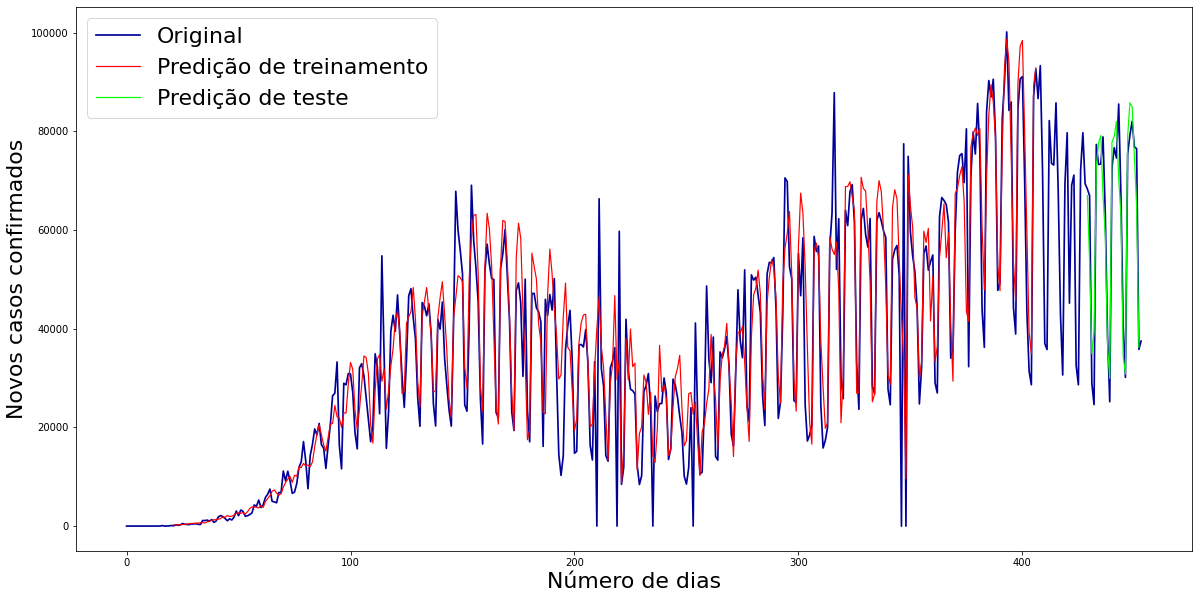

In [223]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [224]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(14, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0509
Epoch 2/100
386/386 - 1s - loss: 0.0173
Epoch 3/100
386/386 - 1s - loss: 0.0139
Epoch 4/100
386/386 - 1s - loss: 0.0130
Epoch 5/100
386/386 - 1s - loss: 0.0121
Epoch 6/100
386/386 - 1s - loss: 0.0126
Epoch 7/100
386/386 - 1s - loss: 0.0119
Epoch 8/100
386/386 - 1s - loss: 0.0120
Epoch 9/100
386/386 - 1s - loss: 0.0117
Epoch 10/100
386/386 - 1s - loss: 0.0112
Epoch 11/100
386/386 - 1s - loss: 0.0114
Epoch 12/100
386/386 - 1s - loss: 0.0113
Epoch 13/100
386/386 - 1s - loss: 0.0109
Epoch 14/100
386/386 - 1s - loss: 0.0109
Epoch 15/100
386/386 - 1s - loss: 0.0107
Epoch 16/100
386/386 - 1s - loss: 0.0107
Epoch 17/100
386/386 - 1s - loss: 0.0106
Epoch 18/100
386/386 - 1s - loss: 0.0106
Epoch 19/100
386/386 - 1s - loss: 0.0107
Epoch 20/100
386/386 - 1s - loss: 0.0110
Epoch 21/100
386/386 - 1s - loss: 0.0100
Epoch 22/100
386/386 - 1s - loss: 0.0109
Epoch 23/100
386/386 - 1s - loss: 0.0103
Epoch 24/100
386/386 - 1s - loss: 0.0104
Epoch 25/100
386/386 - 1s

Train Score: 9397.66 RMSE
Test Score: 12026.93 RMSE


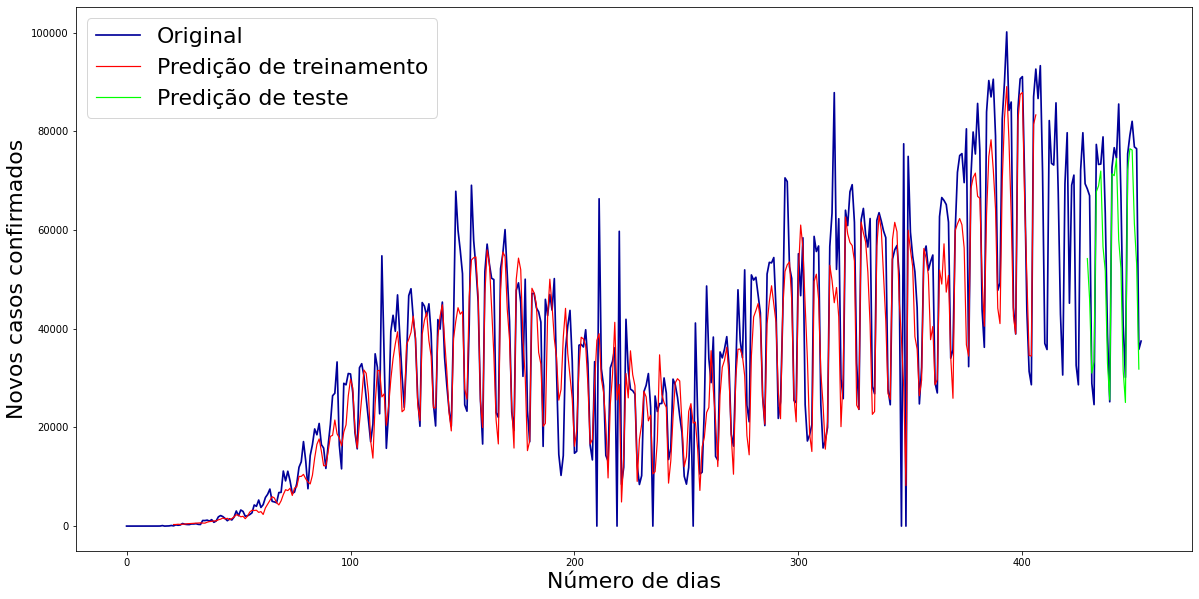

In [225]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [191]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(15, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0278
Epoch 2/100
386/386 - 1s - loss: 0.0151
Epoch 3/100
386/386 - 1s - loss: 0.0134
Epoch 4/100
386/386 - 1s - loss: 0.0123
Epoch 5/100
386/386 - 1s - loss: 0.0120
Epoch 6/100
386/386 - 1s - loss: 0.0120
Epoch 7/100
386/386 - 1s - loss: 0.0118
Epoch 8/100
386/386 - 1s - loss: 0.0113
Epoch 9/100
386/386 - 1s - loss: 0.0116
Epoch 10/100
386/386 - 1s - loss: 0.0114
Epoch 11/100
386/386 - 1s - loss: 0.0114
Epoch 12/100
386/386 - 1s - loss: 0.0108
Epoch 13/100
386/386 - 1s - loss: 0.0107
Epoch 14/100
386/386 - 1s - loss: 0.0108
Epoch 15/100
386/386 - 1s - loss: 0.0107
Epoch 16/100
386/386 - 1s - loss: 0.0106
Epoch 17/100
386/386 - 1s - loss: 0.0106
Epoch 18/100
386/386 - 1s - loss: 0.0105
Epoch 19/100
386/386 - 1s - loss: 0.0107
Epoch 20/100
386/386 - 1s - loss: 0.0103
Epoch 21/100
386/386 - 1s - loss: 0.0105
Epoch 22/100
386/386 - 1s - loss: 0.0107
Epoch 23/100
386/386 - 1s - loss: 0.0106
Epoch 24/100
386/386 - 1s - loss: 0.0102
Epoch 25/100
386/386 - 1s

Train Score: 8717.66 RMSE
Test Score: 9507.92 RMSE


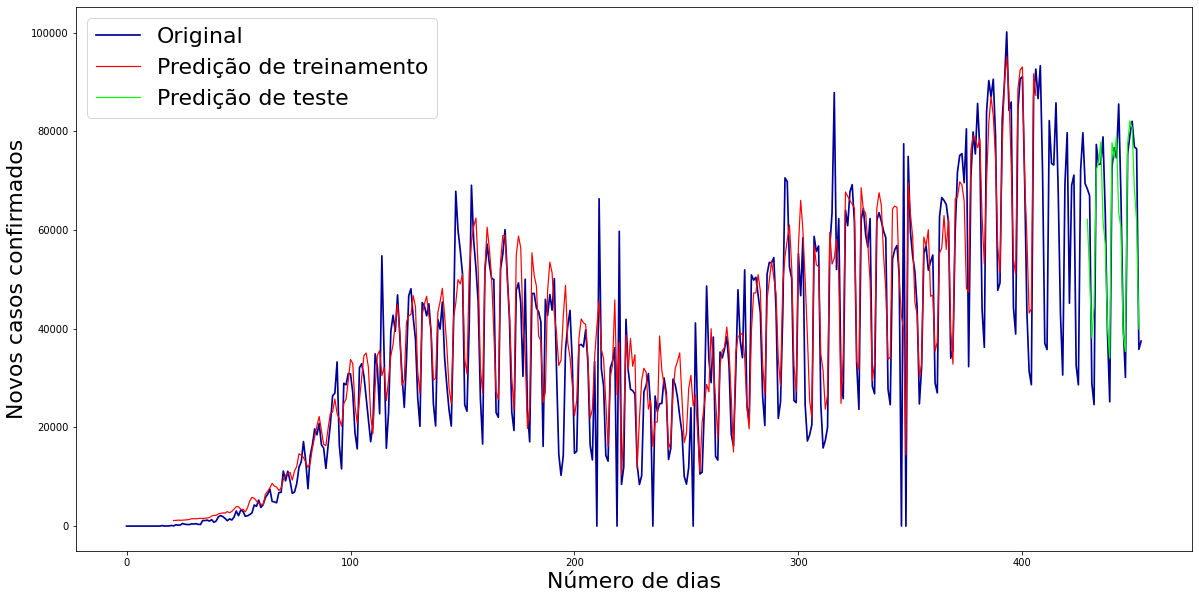

In [192]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [193]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(16, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0184
Epoch 2/100
386/386 - 1s - loss: 0.0125
Epoch 3/100
386/386 - 1s - loss: 0.0116
Epoch 4/100
386/386 - 1s - loss: 0.0116
Epoch 5/100
386/386 - 1s - loss: 0.0116
Epoch 6/100
386/386 - 1s - loss: 0.0115
Epoch 7/100
386/386 - 1s - loss: 0.0113
Epoch 8/100
386/386 - 1s - loss: 0.0111
Epoch 9/100
386/386 - 1s - loss: 0.0107
Epoch 10/100
386/386 - 1s - loss: 0.0106
Epoch 11/100
386/386 - 1s - loss: 0.0108
Epoch 12/100
386/386 - 1s - loss: 0.0109
Epoch 13/100
386/386 - 1s - loss: 0.0104
Epoch 14/100
386/386 - 1s - loss: 0.0108
Epoch 15/100
386/386 - 1s - loss: 0.0107
Epoch 16/100
386/386 - 1s - loss: 0.0103
Epoch 17/100
386/386 - 1s - loss: 0.0105
Epoch 18/100
386/386 - 1s - loss: 0.0107
Epoch 19/100
386/386 - 1s - loss: 0.0107
Epoch 20/100
386/386 - 1s - loss: 0.0109
Epoch 21/100
386/386 - 1s - loss: 0.0104
Epoch 22/100
386/386 - 1s - loss: 0.0103
Epoch 23/100
386/386 - 1s - loss: 0.0101
Epoch 24/100
386/386 - 1s - loss: 0.0104
Epoch 25/100
386/386 - 1s

Train Score: 8581.77 RMSE
Test Score: 9622.96 RMSE


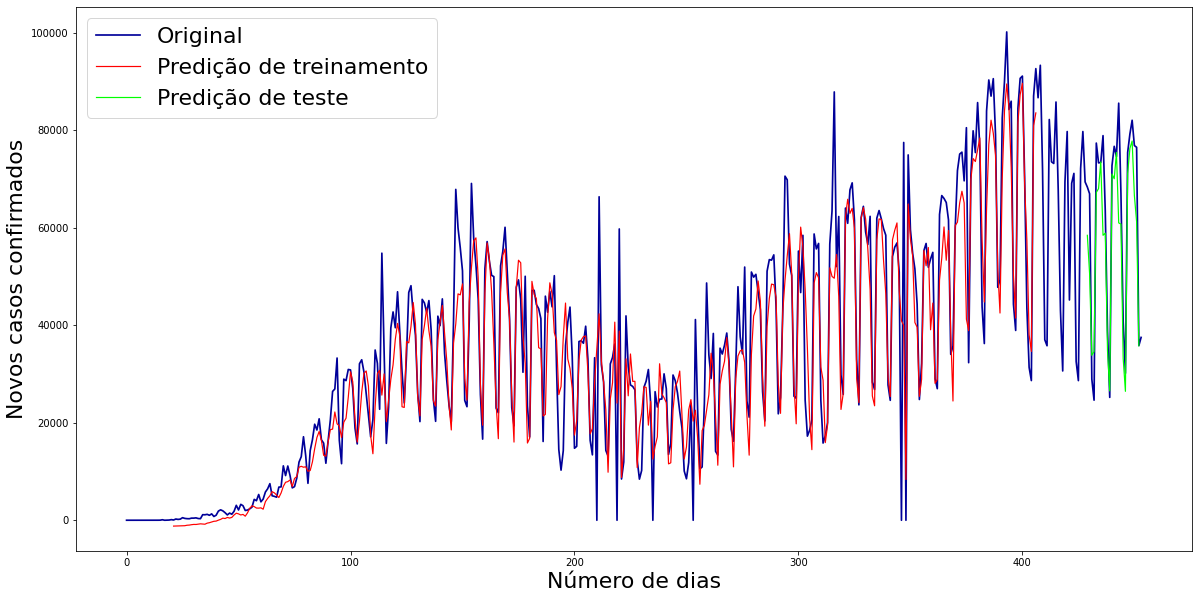

In [194]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

In [195]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(17, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0290
Epoch 2/100
386/386 - 1s - loss: 0.0136
Epoch 3/100
386/386 - 1s - loss: 0.0122
Epoch 4/100
386/386 - 1s - loss: 0.0123
Epoch 5/100
386/386 - 1s - loss: 0.0117
Epoch 6/100
386/386 - 1s - loss: 0.0114
Epoch 7/100
386/386 - 1s - loss: 0.0115
Epoch 8/100
386/386 - 1s - loss: 0.0120
Epoch 9/100
386/386 - 1s - loss: 0.0110
Epoch 10/100
386/386 - 1s - loss: 0.0112
Epoch 11/100
386/386 - 1s - loss: 0.0109
Epoch 12/100
386/386 - 1s - loss: 0.0110
Epoch 13/100
386/386 - 1s - loss: 0.0106
Epoch 14/100
386/386 - 1s - loss: 0.0112
Epoch 15/100
386/386 - 1s - loss: 0.0106
Epoch 16/100
386/386 - 1s - loss: 0.0106
Epoch 17/100
386/386 - 1s - loss: 0.0104
Epoch 18/100
386/386 - 1s - loss: 0.0106
Epoch 19/100
386/386 - 1s - loss: 0.0107
Epoch 20/100
386/386 - 1s - loss: 0.0107
Epoch 21/100
386/386 - 1s - loss: 0.0106
Epoch 22/100
386/386 - 1s - loss: 0.0103
Epoch 23/100
386/386 - 1s - loss: 0.0103
Epoch 24/100
386/386 - 1s - loss: 0.0103
Epoch 25/100
386/386 - 1s

Train Score: 8575.78 RMSE
Test Score: 7202.48 RMSE


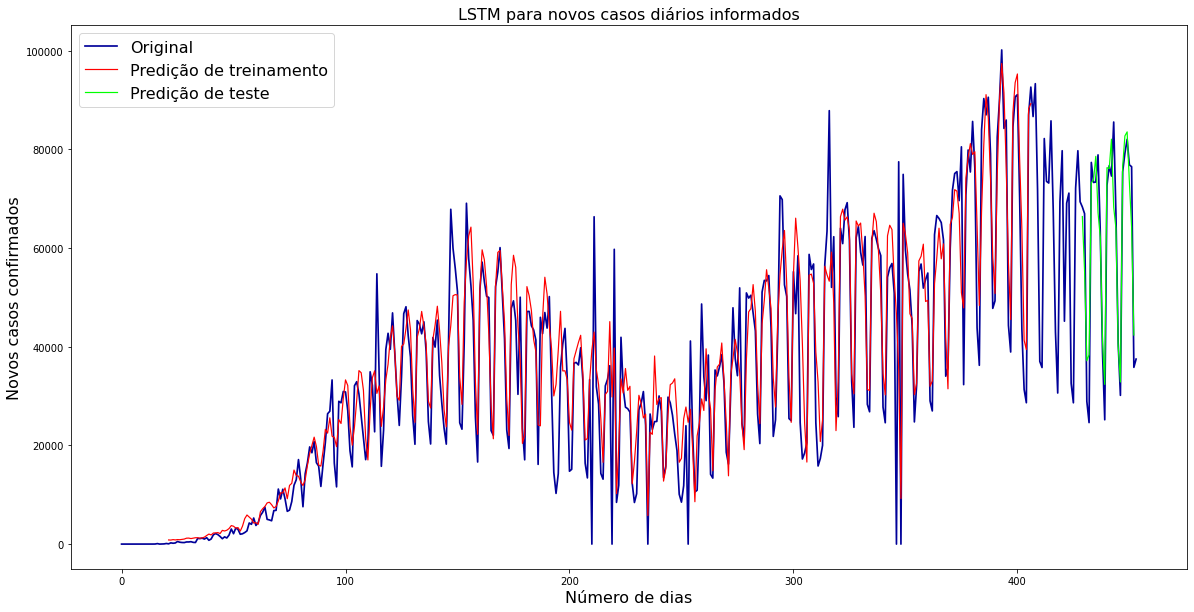

In [196]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')
plt.title('LSTM para novos casos diários informados', fontsize=16)
plt.xlabel('Número de dias', fontsize=16)
plt.ylabel('Novos casos confirmados', fontsize=16)

plt.legend(fontsize=16)
plt.show()

#teste18

In [211]:
look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(18, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
386/386 - 2s - loss: 0.0260
Epoch 2/100
386/386 - 1s - loss: 0.0148
Epoch 3/100
386/386 - 1s - loss: 0.0127
Epoch 4/100
386/386 - 1s - loss: 0.0121
Epoch 5/100
386/386 - 1s - loss: 0.0125
Epoch 6/100
386/386 - 1s - loss: 0.0112
Epoch 7/100
386/386 - 1s - loss: 0.0112
Epoch 8/100
386/386 - 1s - loss: 0.0111
Epoch 9/100
386/386 - 1s - loss: 0.0111
Epoch 10/100
386/386 - 1s - loss: 0.0109
Epoch 11/100
386/386 - 1s - loss: 0.0111
Epoch 12/100
386/386 - 1s - loss: 0.0109
Epoch 13/100
386/386 - 1s - loss: 0.0105
Epoch 14/100
386/386 - 1s - loss: 0.0107
Epoch 15/100
386/386 - 1s - loss: 0.0105
Epoch 16/100
386/386 - 1s - loss: 0.0107
Epoch 17/100
386/386 - 1s - loss: 0.0102
Epoch 18/100
386/386 - 1s - loss: 0.0107
Epoch 19/100
386/386 - 1s - loss: 0.0103
Epoch 20/100
386/386 - 1s - loss: 0.0106
Epoch 21/100
386/386 - 1s - loss: 0.0102
Epoch 22/100
386/386 - 1s - loss: 0.0102
Epoch 23/100
386/386 - 1s - loss: 0.0103
Epoch 24/100
386/386 - 1s - loss: 0.0102
Epoch 25/100
386/386 - 1s

Train Score: 8510.21 RMSE
Test Score: 6575.54 RMSE


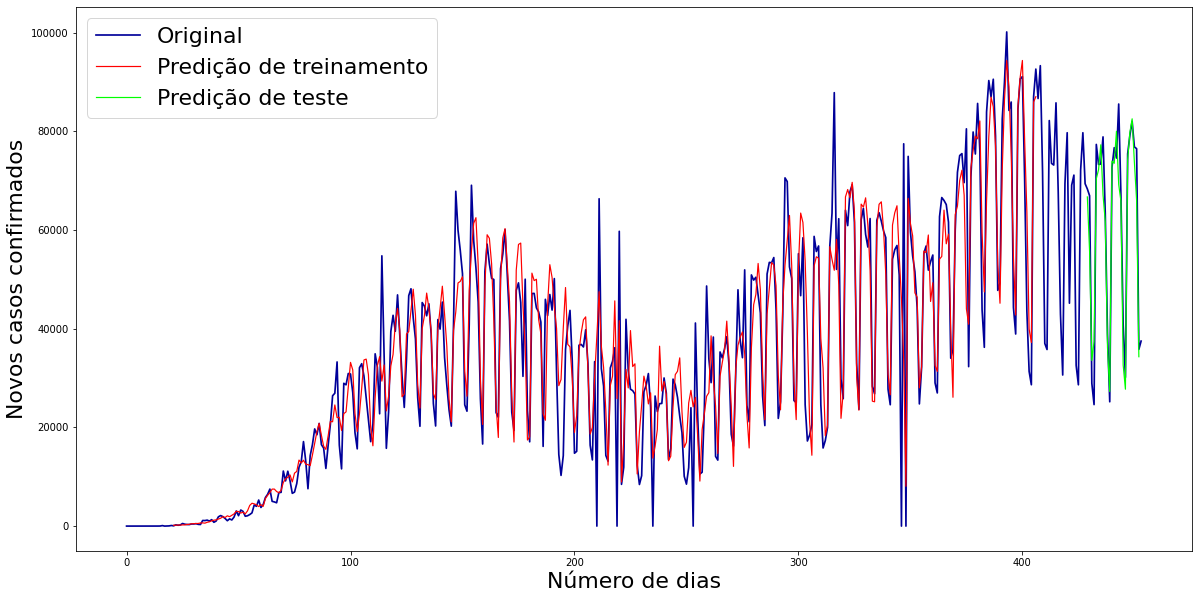

In [212]:
plt.figure(figsize=(20,10))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

#Regressão linear

Train Score: 10553.99 RMSE
Test Score: 10799.77 RMSE


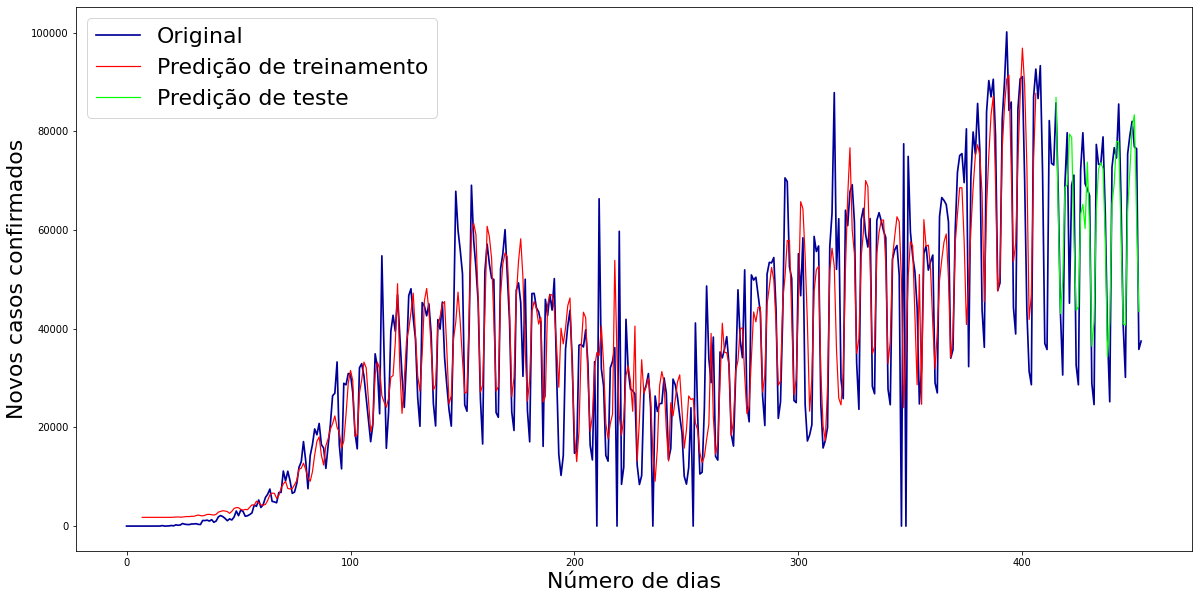

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1]))

# create and fit the LSTM network
model = LinearRegression()

model.fit(trainX, trainY)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict=pd.DataFrame(trainPredict)
trainPredict = scaler.inverse_transform(trainPredict)

trainY = scaler.inverse_transform([trainY])

testPredict=pd.DataFrame(testPredict)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')


plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()

Train Score: 10016.11 RMSE
Test Score: 5579.47 RMSE


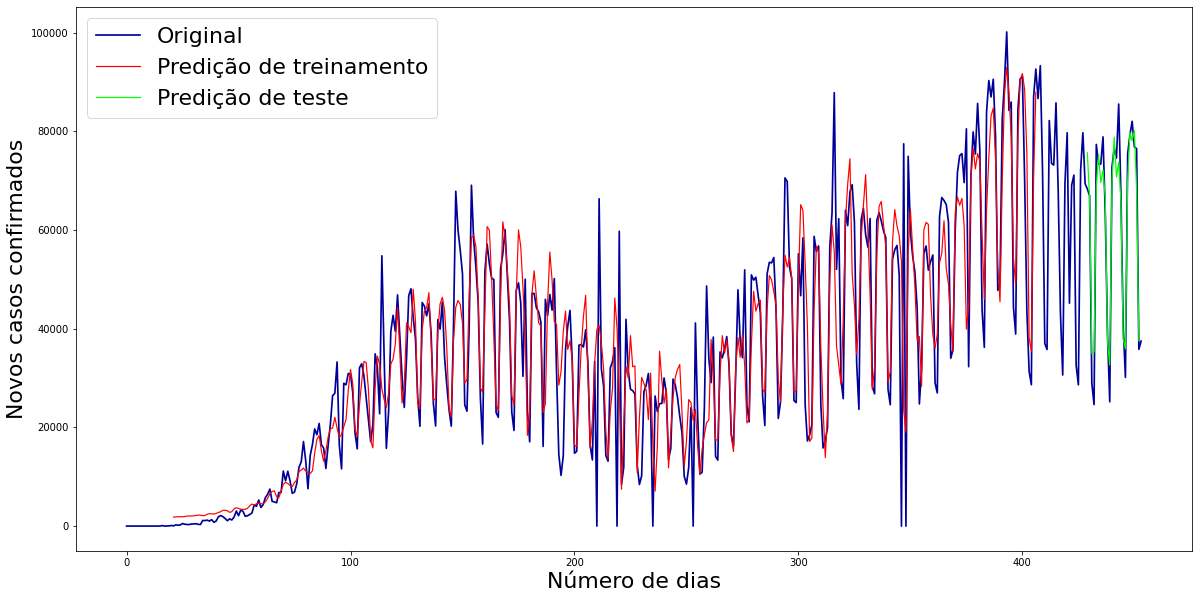

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

look_back = 21
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1]))

# create and fit the LSTM network
model = LinearRegression()

model.fit(trainX, trainY)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict=pd.DataFrame(trainPredict)
trainPredict = scaler.inverse_transform(trainPredict)

trainY = scaler.inverse_transform([trainY])

testPredict=pd.DataFrame(testPredict)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), color='#000099', linewidth=1.7, linestyle='solid', label='Original')
plt.plot(trainPredictPlot, color='red', linewidth=1.2, linestyle='solid', label='Predição de treinamento')
plt.plot(testPredictPlot, color='#00FF00', linewidth=1.2, linestyle='solid', label='Predição de teste')

plt.xlabel('Número de dias', fontsize=22)
plt.ylabel('Novos casos confirmados', fontsize=22)

plt.legend(fontsize=22)
plt.show()